# Q1

#### Wandb login

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deepak_singh_ma23m006 (deepak_singh_ma23m006-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

#### load dataset, define category, plotting each class image on wandb

In [ ]:
#Load Fashion-MNIST data and return training and test sets.
def load_dataset():   
    (train_imgs, train_labels), (test_imgs, test_labels) = fashion_mnist.load_data()
    return train_imgs, train_labels, test_imgs, test_labels

#mapping of label indices to category names.
def get_category_names():
    return {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

#Plot the first encountered image for each category.
def render_single_instance_per_category(images, labels, cat_names):
    
    unique_samples = {} #Iterate through images until we've found one for each category.


    for img, lbl in zip(images, labels):
        if lbl not in unique_samples:
            unique_samples[lbl] = img
        if len(unique_samples) == 10:
            break

    plt.figure(figsize=(20, 2))
    for pos, (lbl, img) in enumerate(unique_samples.items(), start=1):
        ax = plt.subplot(1, 10, pos)
        ax.imshow(img, cmap="BrBG_r")
        ax.set_title(cat_names[lbl])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


#Log two batches of images to Weights & Biases:
def log_image_batches(training_images, training_labels, cat_names):
    run = wandb.init(project="DL_Assignment1", name="question_1")
    
    batch_one = [
        wandb.Image(training_images[i], caption=f"{cat_names[training_labels[i]]} (index {i})")
        for i in range(18)
    ]
    batch_two = [
        wandb.Image(training_images[i], caption=f"{cat_names[training_labels[i]]} (index {i})")
        for i in range(18, 36)
    ]
    
    wandb.log({"First Batch": batch_one, "Second Batch": batch_two})
    run.finish()




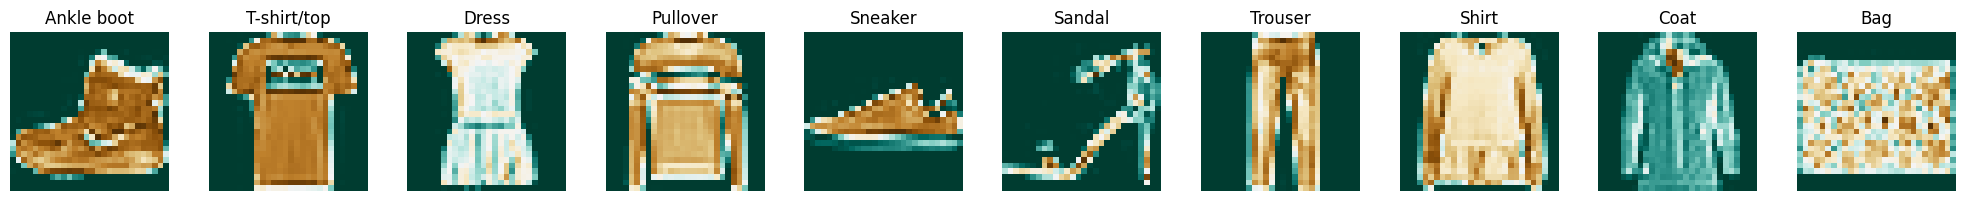

In [ ]:
# Load the dataset and category names.
train_imgs, train_lbls, _, _ = load_dataset()
categories = get_category_names()
    
# Render one image per category.
render_single_instance_per_category(train_imgs, train_lbls, categories)
    
# Log two batches of images.
log_image_batches(train_imgs, train_lbls, categories)



# Q2

#### defining x_train,y_train,x_test,y_test and class category

In [ ]:
#loading Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# class names for the Fashion-MNIST labels
category_class = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]



#### normalizing and one hot encoding

In [4]:
# Flatten images to 784-dimensional vectors and normalize pixel values to [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test  = X_test.reshape(-1, 28*28) / 255.0

# One-hot encoding for labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train, 10)
y_test_onehot  = one_hot(y_test, 10)


#### Defining Neural netwok class 

In [5]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.1):
        self.layer_sizes = layer_sizes      # layer of neural network
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        
        #initialize weights and biases
        for i in range(self.num_layers - 1):
            # "He" initialization for layers with ReLU activation
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        # Numerical stability: subtract max from each row
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []          # Linear combinations
        self.activations = [X]  # List of activations, starting with input
        
        A = X
        # Forward pass for hidden layers using ReLU activation
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.relu(z)
            self.activations.append(A)
        
        # Output layer: linear combination then softmax activation
        z = self.activations[-1].dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        A = self.softmax(z)
        self.activations.append(A)
        return A
    

    #cross-entropy loss
    def compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        return loss
    

    #computes gradients and updates parameters.
    def backward(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer delta: derivative of softmax with cross-entropy loss
        delta = (Y_pred - Y_true) / m  
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.relu_derivative(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # Update parameters using gradient descent
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i]  -= self.learning_rate * db[i]
    
    def predict(self, X):
        Y_pred = self.forward(X)
        return np.argmax(Y_pred, axis=1)

#### Flexibility - can adjust the hidden layers/neuron counts as desired.

In [6]:
# Define network architecture; adjust the hidden layers/neuron counts as desired.
hidden_layers = [128, 64]  # Modify this list to change the number of hidden layers and neurons
layer_sizes = [784] + hidden_layers + [10]  # Input layer, hidden layers, output layer


#### training and tracking on wandb

In [7]:
# Initialize a wandb run
wandb.init(project="DL_Assignment1", name="question_2._")
nn = NeuralNetwork(layer_sizes, learning_rate=0.1)

# Training parameters
num_epochs = 50
batch_size = 64
num_batches = X_train.shape[0] // batch_size

for epoch in range(num_epochs):
    # Shuffle training data at the beginning of each epoch
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    y_train_onehot_shuffled = y_train_onehot[perm]
    
    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_onehot_shuffled[start:end]
        
        # Forward pass
        Y_pred = nn.forward(X_batch)
        loss = nn.compute_loss(Y_pred, y_batch)
        epoch_loss += loss
        
        # Backward pass and parameter update
        nn.backward(Y_pred, y_batch)
    
    avg_loss = epoch_loss / num_batches
    train_predictions = nn.predict(X_train)
    train_accuracy = np.mean(train_predictions == y_train)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {train_accuracy:.4f}")
    wandb.log({"epoch": epoch+1, "loss": avg_loss, "accuracy": train_accuracy})

# Evaluate on the test set
test_predictions = nn.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
wandb.log({"test_accuracy": test_accuracy})


Epoch 1/50 - Loss: 0.5740 - Accuracy: 0.8478
Epoch 2/50 - Loss: 0.4118 - Accuracy: 0.8608
Epoch 3/50 - Loss: 0.3693 - Accuracy: 0.8750
Epoch 4/50 - Loss: 0.3441 - Accuracy: 0.8813
Epoch 5/50 - Loss: 0.3254 - Accuracy: 0.8920
Epoch 6/50 - Loss: 0.3093 - Accuracy: 0.8917
Epoch 7/50 - Loss: 0.2971 - Accuracy: 0.8994
Epoch 8/50 - Loss: 0.2873 - Accuracy: 0.8937
Epoch 9/50 - Loss: 0.2765 - Accuracy: 0.9060
Epoch 10/50 - Loss: 0.2673 - Accuracy: 0.9044
Epoch 11/50 - Loss: 0.2589 - Accuracy: 0.9138
Epoch 12/50 - Loss: 0.2523 - Accuracy: 0.9081
Epoch 13/50 - Loss: 0.2451 - Accuracy: 0.9156
Epoch 14/50 - Loss: 0.2390 - Accuracy: 0.9157
Epoch 15/50 - Loss: 0.2341 - Accuracy: 0.9165
Epoch 16/50 - Loss: 0.2263 - Accuracy: 0.9206
Epoch 17/50 - Loss: 0.2232 - Accuracy: 0.9192
Epoch 18/50 - Loss: 0.2185 - Accuracy: 0.9170
Epoch 19/50 - Loss: 0.2136 - Accuracy: 0.9231
Epoch 20/50 - Loss: 0.2111 - Accuracy: 0.9268
Epoch 21/50 - Loss: 0.2036 - Accuracy: 0.9325
Epoch 22/50 - Loss: 0.2001 - Accuracy: 0.93

#### probability distributions of 10 classes


Probability distribution for test image at index 0:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 1.0000

Probability distribution for test image at index 10:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0252
Dress: 0.0000
Coat: 0.9706
Sandal: 0.0000
Shirt: 0.0042
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000

Probability distribution for test image at index 20:
T-shirt/top: 0.0045
Trouser: 0.0000
Pullover: 0.9920
Dress: 0.0000
Coat: 0.0030
Sandal: 0.0000
Shirt: 0.0005
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000

Probability distribution for test image at index 30:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0000
Bag: 1.0000
Ankle boot: 0.0000


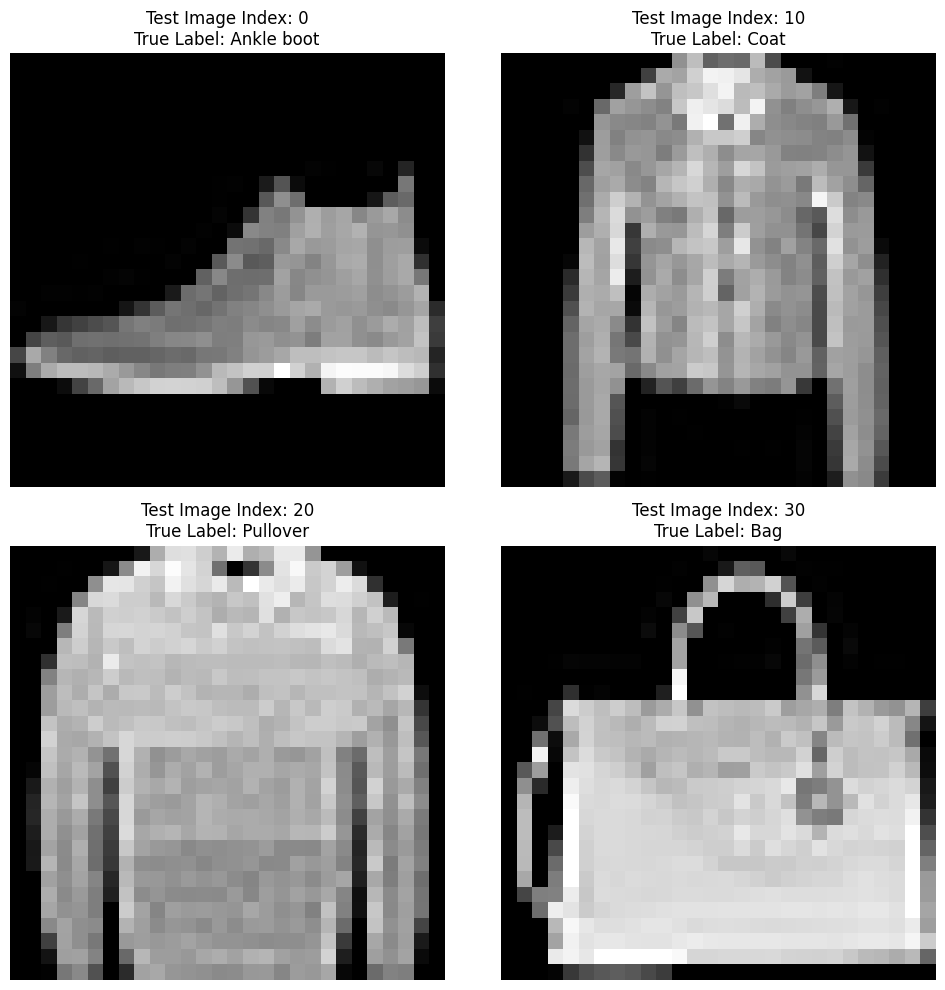

In [9]:
# List of sample indices for which we find probability distributions
sample_indices = [0, 10, 20, 30]

# Create a wandb Table to log multiple probability distributions
table_rows = []
for sample_idx in sample_indices:
    sample_input = X_test[sample_idx:sample_idx+1]  # Maintain batch dimension
    prob_distribution = nn.forward(sample_input)
    
    print(f"\nProbability distribution for test image at index {sample_idx}:")
    for i, prob in enumerate(prob_distribution[0]):
        print(f"{category_class[i]}: {prob:.4f}")
        table_rows.append([sample_idx, category_class[i], prob])
    
# Log the table to wandb for visualization
prob_table = wandb.Table(data=table_rows, columns=["Sample Index", "Class", "Probability"])
wandb.log({"sample_prob_distributions": prob_table})

# Visualize one of the sample images along with its predicted label:
import matplotlib.pyplot as plt

sample_indices = [0, 10, 20, 30]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    sample_image = X_test[sample_idx].reshape(28, 28)
    axes[idx].imshow(sample_image, cmap='gray')
    axes[idx].set_title(f"Test Image Index: {sample_idx}\nTrue Label: {category_class[y_test[sample_idx]]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [10]:
wandb.finish()


accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▅▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇█▇▇▇█▇███
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
accuracy,0.96003
epoch,50
loss,0.12007
test_accuracy,0.8897


# Q3

#### defining neural network 

In [ ]:

class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        #initialize weights and biases (using He initialization for ReLU)
        for i in range(self.num_layers - 1):
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []               # Store linear combinations for backpropagation
        self.activations = [X]      # Input is the first activation
        
        A = X
        # Hidden layers with ReLU activation
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.relu(z)
            self.activations.append(A)
        
        # Output layer: linear -> softmax
        z = self.activations[-1].dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        A = self.softmax(z)
        self.activations.append(A)
        return A
    
    # cross-entropy loss.
    def compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        return loss
    

    # forward, compute loss function are same but backward  is different 


    
        #Compute gradients for weights and biases via backpropagation.
            #dW: list of gradients for weights
            #db: list of gradients for biases
        
    def backward(self, Y_pred, Y_true):
        
        m = Y_true.shape[0]
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Compute gradient at output layer (softmax + cross-entropy)
        delta = (Y_pred - Y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Propagate backwards through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.relu_derivative(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        return dW, db


#### optimizers

In [29]:
# SGD Optimizer
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

# Momentum-Based Gradient Descent
class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

# Nesterov Accelerated Gradient Descent
class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            # Save previous velocity
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            # Update velocity
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            # Nesterov update (lookahead)
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

# RMSProp Optimizer
class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

# Adam Optimizer
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1 ** t)
            v_hat_w = self.vw[i] / (1 - self.beta2 ** t)
            m_hat_b = self.mb[i] / (1 - self.beta1 ** t)
            v_hat_b = self.vb[i] / (1 - self.beta2 ** t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

# Nadam Optimizer (Adam with Nesterov momentum) - Corrected Bias Update
class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat = self.mw[i] / (1 - self.beta1 ** t)
            v_hat = self.vw[i] / (1 - self.beta2 ** t)
            m_hat_b = self.mb[i] / (1 - self.beta1 ** t)
            v_hat_b = self.vb[i] / (1 - self.beta2 ** t)
            
            weights[i] -= self.learning_rate * (self.beta1 * m_hat + (1 - self.beta1) * dW[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat) + self.epsilon)
            # Corrected: use v_hat_b for bias update
            biases[i]  -= self.learning_rate * (self.beta1 * m_hat_b + (1 - self.beta1) * db[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat_b) + self.epsilon)


#### training with all optimizers and comparing 

In [ ]:
# Define a dictionary mapping optimizer names to functions that return a new optimizer instance.
optimizers_dict = {
    "SGD": lambda: SGD(learning_rate=0.01),
    "Momentum": lambda: Momentum(learning_rate=0.01, momentum=0.9),
    "Nesterov": lambda: Nesterov(learning_rate=0.01, momentum=0.9),
    "RMSProp": lambda: RMSProp(learning_rate=0.001, decay_rate=0.9),
    "Adam": lambda: Adam(learning_rate=0.001, beta1=0.9, beta2=0.999),
    "Nadam": lambda: Nadam(learning_rate=0.001, beta1=0.9, beta2=0.999)
}

# Common training parameters
# num_epochs: number of training epochs (it is flexible i.e can be change)
# batch_size: number of samples per batch
num_epochs = 10
batch_size = 32
num_batches = X_train.shape[0] // batch_size
layer_sizes = [784, 128, 64, 10]

# To store summary results for each optimizer.
results = []

# Loop over each optimizer and run a separate training experiment.
for opt_name, opt_fn in optimizers_dict.items():
    # Initialize a new wandb run for each optimizer.
    run = wandb.init(project="DL_Assignment1", 
                     name=f"question_3_{opt_name}", 
                     reinit=True, 
                     config={
                         "optimizer": opt_name,
                         "num_epochs": num_epochs,
                         "batch_size": batch_size,
                         "layer_sizes": layer_sizes
                     })
    
    # Initialize a new neural network and optimizer instance.
    nn = NeuralNetwork(layer_sizes)
    optimizer = opt_fn()
    
    global_step = 1
    epoch_losses = []
    
    print(f"\nStarting training with optimizer: {opt_name}")
    for epoch in range(num_epochs):
        # Shuffle training data at the start of each epoch.
        perm = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[perm]
        y_train_onehot_shuffled = y_train_onehot[perm]
        
        epoch_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_onehot_shuffled[start:end]
            
            # Forward pass.
            Y_pred = nn.forward(X_batch)
            loss = nn.compute_loss(Y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass: compute gradients.
            dW, db = nn.backward(Y_pred, y_batch)
            
            # Update parameters using the chosen optimizer.
            optimizer.update(nn.weights, nn.biases, dW, db, global_step)
            global_step += 1
        
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Evaluate training accuracy on the entire training set.
        train_predictions = np.argmax(nn.forward(X_train), axis=1)
        train_accuracy = np.mean(train_predictions == y_train)
        
        print(f"{opt_name} | Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        wandb.log({"epoch": epoch+1, "loss": avg_loss, "train_accuracy": train_accuracy})
    
    # Evaluate on the test set.
    test_predictions = np.argmax(nn.forward(X_test), axis=1)
    test_accuracy = np.mean(test_predictions == y_test)
    print(f"{opt_name} | Test Accuracy: {test_accuracy:.4f}")
    wandb.log({"test_accuracy": test_accuracy})
    
    # Save final results for this optimizer.
    results.append({
        "Optimizer": opt_name,
        "Final Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Final Loss": avg_loss
    })
    
    run.finish()



Starting training with optimizer: SGD
SGD | Epoch 1/10 - Loss: 0.7043 - Train Accuracy: 0.8171
SGD | Epoch 2/10 - Loss: 0.4826 - Train Accuracy: 0.8347
SGD | Epoch 3/10 - Loss: 0.4412 - Train Accuracy: 0.8542
SGD | Epoch 4/10 - Loss: 0.4154 - Train Accuracy: 0.8608
SGD | Epoch 5/10 - Loss: 0.3979 - Train Accuracy: 0.8553
SGD | Epoch 6/10 - Loss: 0.3838 - Train Accuracy: 0.8743
SGD | Epoch 7/10 - Loss: 0.3706 - Train Accuracy: 0.8730
SGD | Epoch 8/10 - Loss: 0.3584 - Train Accuracy: 0.8715
SGD | Epoch 9/10 - Loss: 0.3491 - Train Accuracy: 0.8735
SGD | Epoch 10/10 - Loss: 0.3407 - Train Accuracy: 0.8848
SGD | Test Accuracy: 0.8629


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▅▆▅▇▇▇▇█
epoch,10
loss,0.34065
test_accuracy,0.8629
train_accuracy,0.88477



Starting training with optimizer: Momentum
Momentum | Epoch 1/10 - Loss: 0.5249 - Train Accuracy: 0.8599
Momentum | Epoch 2/10 - Loss: 0.3869 - Train Accuracy: 0.8743
Momentum | Epoch 3/10 - Loss: 0.3526 - Train Accuracy: 0.8618
Momentum | Epoch 4/10 - Loss: 0.3298 - Train Accuracy: 0.8835
Momentum | Epoch 5/10 - Loss: 0.3124 - Train Accuracy: 0.8799
Momentum | Epoch 6/10 - Loss: 0.2997 - Train Accuracy: 0.8910
Momentum | Epoch 7/10 - Loss: 0.2861 - Train Accuracy: 0.9024
Momentum | Epoch 8/10 - Loss: 0.2760 - Train Accuracy: 0.9029
Momentum | Epoch 9/10 - Loss: 0.2684 - Train Accuracy: 0.9079
Momentum | Epoch 10/10 - Loss: 0.2585 - Train Accuracy: 0.9089
Momentum | Test Accuracy: 0.8796


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▁▄▄▅▇▇██
epoch,10
loss,0.25854
test_accuracy,0.8796
train_accuracy,0.9089



Starting training with optimizer: Nesterov
Nesterov | Epoch 1/10 - Loss: 0.5050 - Train Accuracy: 0.8601
Nesterov | Epoch 2/10 - Loss: 0.3834 - Train Accuracy: 0.8716
Nesterov | Epoch 3/10 - Loss: 0.3491 - Train Accuracy: 0.8644
Nesterov | Epoch 4/10 - Loss: 0.3253 - Train Accuracy: 0.8959
Nesterov | Epoch 5/10 - Loss: 0.3074 - Train Accuracy: 0.8903
Nesterov | Epoch 6/10 - Loss: 0.2934 - Train Accuracy: 0.9006
Nesterov | Epoch 7/10 - Loss: 0.2838 - Train Accuracy: 0.9030
Nesterov | Epoch 8/10 - Loss: 0.2723 - Train Accuracy: 0.9025
Nesterov | Epoch 9/10 - Loss: 0.2626 - Train Accuracy: 0.9025
Nesterov | Epoch 10/10 - Loss: 0.2547 - Train Accuracy: 0.9044
Nesterov | Test Accuracy: 0.8751


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▂▇▆▇████
epoch,10
loss,0.25465
test_accuracy,0.8751
train_accuracy,0.90442



Starting training with optimizer: RMSProp
RMSProp | Epoch 1/10 - Loss: 0.5039 - Train Accuracy: 0.8410
RMSProp | Epoch 2/10 - Loss: 0.3808 - Train Accuracy: 0.8796
RMSProp | Epoch 3/10 - Loss: 0.3510 - Train Accuracy: 0.8697
RMSProp | Epoch 4/10 - Loss: 0.3367 - Train Accuracy: 0.8835
RMSProp | Epoch 5/10 - Loss: 0.3316 - Train Accuracy: 0.8891
RMSProp | Epoch 6/10 - Loss: 0.3253 - Train Accuracy: 0.8896
RMSProp | Epoch 7/10 - Loss: 0.3185 - Train Accuracy: 0.8973
RMSProp | Epoch 8/10 - Loss: 0.3136 - Train Accuracy: 0.8925
RMSProp | Epoch 9/10 - Loss: 0.3142 - Train Accuracy: 0.9017
RMSProp | Epoch 10/10 - Loss: 0.3103 - Train Accuracy: 0.8888
RMSProp | Test Accuracy: 0.8626


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▂▂▁▁▁▁
test_accuracy,▁
train_accuracy,▁▅▄▆▇▇▇▇█▇
epoch,10
loss,0.31032
test_accuracy,0.8626
train_accuracy,0.88882



Starting training with optimizer: Adam
Adam | Epoch 1/10 - Loss: 0.4959 - Train Accuracy: 0.8569
Adam | Epoch 2/10 - Loss: 0.3660 - Train Accuracy: 0.8781
Adam | Epoch 3/10 - Loss: 0.3324 - Train Accuracy: 0.8861
Adam | Epoch 4/10 - Loss: 0.3089 - Train Accuracy: 0.8876
Adam | Epoch 5/10 - Loss: 0.2936 - Train Accuracy: 0.9016
Adam | Epoch 6/10 - Loss: 0.2783 - Train Accuracy: 0.9042
Adam | Epoch 7/10 - Loss: 0.2665 - Train Accuracy: 0.9005
Adam | Epoch 8/10 - Loss: 0.2538 - Train Accuracy: 0.9049
Adam | Epoch 9/10 - Loss: 0.2477 - Train Accuracy: 0.9141
Adam | Epoch 10/10 - Loss: 0.2403 - Train Accuracy: 0.9147
Adam | Test Accuracy: 0.8809


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▄▅▅▆▇▆▇██
epoch,10
loss,0.24025
test_accuracy,0.8809
train_accuracy,0.91472



Starting training with optimizer: Nadam
Nadam | Epoch 1/10 - Loss: 0.4721 - Train Accuracy: 0.8475
Nadam | Epoch 2/10 - Loss: 0.3567 - Train Accuracy: 0.8818
Nadam | Epoch 3/10 - Loss: 0.3243 - Train Accuracy: 0.8928
Nadam | Epoch 4/10 - Loss: 0.3048 - Train Accuracy: 0.8989
Nadam | Epoch 5/10 - Loss: 0.2864 - Train Accuracy: 0.9020
Nadam | Epoch 6/10 - Loss: 0.2756 - Train Accuracy: 0.9036
Nadam | Epoch 7/10 - Loss: 0.2618 - Train Accuracy: 0.9050
Nadam | Epoch 8/10 - Loss: 0.2517 - Train Accuracy: 0.9122
Nadam | Epoch 9/10 - Loss: 0.2415 - Train Accuracy: 0.9156
Nadam | Epoch 10/10 - Loss: 0.2326 - Train Accuracy: 0.9228
Nadam | Test Accuracy: 0.8879


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
test_accuracy,▁
train_accuracy,▁▄▅▆▆▆▆▇▇█
epoch,10
loss,0.23259
test_accuracy,0.8879
train_accuracy,0.92283


In [14]:
# Create a wandb Table with the summary results.
summary_table = wandb.Table(columns=["Optimizer", "Final Train Accuracy", "Test Accuracy", "Final Loss"])
for res in results:
    summary_table.add_data(res["Optimizer"], res["Final Train Accuracy"], res["Test Accuracy"], res["Final Loss"])

# Initialize a new run to log the summary comparison.
summary_run = wandb.init(project="DL_Assignment1", name="question_3_summary", reinit=True)
wandb.log({"Optimizer Comparison": summary_table})
summary_run.finish()

# Optionally, print the summary table.
print("\nSummary of Optimizer Performance:")
for res in results:
    print(f"{res['Optimizer']:10s} | Train Acc: {res['Final Train Accuracy']:.4f} | Test Acc: {res['Test Accuracy']:.4f} | Final Loss: {res['Final Loss']:.4f}")



Summary of Optimizer Performance:
SGD        | Train Acc: 0.8675 | Test Acc: 0.8475 | Final Loss: 0.3801
Momentum   | Train Acc: 0.9016 | Test Acc: 0.8724 | Final Loss: 0.2667
Nesterov   | Train Acc: 0.9068 | Test Acc: 0.8730 | Final Loss: 0.2590
RMSProp    | Train Acc: 0.9071 | Test Acc: 0.8751 | Final Loss: 0.2567
Adam       | Train Acc: 0.9124 | Test Acc: 0.8792 | Final Loss: 0.2392
Nadam      | Train Acc: 0.9139 | Test Acc: 0.8827 | Final Loss: 0.2326


# Q4

#### importing necessary libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

#### loadig data , splitting data into train/test/validation , normalize and one hot encoding

In [24]:
# 1. Load Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# 3. Flatten and normalize images (28x28 -> 784) in [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# 4. One-hot encode labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


#### defining sweep config as given in question

In [4]:
sweep_config = {
    'method': 'bayes',  # or 'grid', 'bayes'
    'metric': {
      'name': 'val_loss', 
      'goal': 'minimize' 
    },
    'parameters': {
        'epochs': {
            'values': [5, 10]
        },
        'num_hidden_layers': {
            'values': [3, 4, 5]
        },
        'hidden_layer_size': {
            'values': [32, 64, 128]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_init': {
            'values': ['random', 'xavier']
        },
        'activation_function': {
            'values': ['sigmoid', 'tanh', 'relu']
        }
    }
}


In [18]:
#Xavier/Glorot initialization.
def xavier_init(fan_in, fan_out):
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,weight_init='random', activation='relu', weight_decay=0.0):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_name = activation
        self.weight_decay = weight_decay
        
        # Activation
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x)*(1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        # Build architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # simple random normal
                W = np.random.randn(fan_in, fan_out)*0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true):
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer
        delta = (y_pred - y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db


In [ ]:
def train_model_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # 1. Build the MLP
        mlp = SimpleMLP(
            input_dim=784,
            num_hidden_layers=config.num_hidden_layers,
            hidden_size=config.hidden_layer_size,
            output_dim=10,
            weight_init=config.weight_init,
            activation=config.activation_function,
            weight_decay=config.weight_decay
        )
        
        # 2. Choose the optimizer
        if config.optimizer == 'sgd':
            optimizer = SGD(learning_rate=config.learning_rate)
        elif config.optimizer == 'momentum':
            optimizer = Momentum(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'nesterov':
            optimizer = Nesterov(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'rmsprop':
            optimizer = RMSProp(learning_rate=config.learning_rate, decay_rate=0.9)
        elif config.optimizer == 'adam':
            optimizer = Adam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        elif config.optimizer == 'nadam':
            optimizer = Nadam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        else:
            raise ValueError("Unknown optimizer")
        
        # 3. Training loop
        global_step = 1
        for epoch in range(config.epochs):
            # Shuffle training data
            num_samples = X_train.shape[0]
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train_oh[indices]
            
            for start_idx in range(0, num_samples, config.batch_size):
                end_idx = start_idx + config.batch_size
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward
                y_pred = mlp.forward(X_batch)
                
                # Compute gradients (no update yet)
                dW, db = mlp.backward(y_pred, y_batch)
                
                # Optimizer update
                optimizer.update(mlp.weights, mlp.biases, dW, db, global_step)
                global_step += 1
            
            # Evaluate on validation set
            val_pred = mlp.forward(X_val)
            val_loss = mlp.compute_loss(val_pred, y_val_oh)
            val_acc  = np.mean(np.argmax(val_pred, axis=1) == y_val)
            
            # Log to wandb
            wandb.log({
                "epoch": epoch+1,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })
        
        # Evaluate on test set
        test_pred = mlp.forward(X_test)
        test_loss = mlp.compute_loss(test_pred, y_test_oh)
        test_acc  = np.mean(np.argmax(test_pred, axis=1) == y_test)
        
        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})
        
        # Giving the run a descriptive name
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_act_{config.activation_function}_opt_{config.optimizer}"
        wandb.run.name = run_name
        
        print(f"Run {run_name} finished with val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")


In [9]:
# Create the sweep in W&B
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment1")

# Launch the sweep agent
# For example, we run 10 random combinations. Increase if desired.
wandb.agent(sweep_id, train_model_sweep, count=200)

Create sweep with ID: 1xzchkm3
Sweep URL: https://wandb.ai/deepak_singh_ma23m006-iit-madras/DL_Assignment1/sweeps/1xzchkm3


wandb: Agent Starting Run: ytr920ws with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_sgd finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅█▃▄▄▅▃▇▅
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30204
val_accuracy,0.09333
val_loss,2.30236


wandb: Agent Starting Run: 8vbtbp47 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_relu_opt_nesterov finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▄▆█
epoch,5
test_accuracy,0.1
test_loss,2.30258
val_accuracy,0.09333
val_loss,2.30263


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5vkj05je with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8078, test_acc=0.7952


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▄▆▇▇███
val_loss,██▇▅▄▃▂▂▁▁
epoch,10
test_accuracy,0.7952
test_loss,0.61017
val_accuracy,0.80783
val_loss,0.58016


wandb: Agent Starting Run: vlnp7k7x with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_sigmoid_opt_sgd finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30274
val_accuracy,0.09833
val_loss,2.30289


wandb: Agent Starting Run: art15e5g with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8590, test_acc=0.8425


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8425
test_loss,0.45052
val_accuracy,0.859
val_loss,0.42148


wandb: Agent Starting Run: s197k4p4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8570, test_acc=0.8443


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇█▇██
val_loss,█▄▃▃▂▂▁▂▁▁
epoch,10
test_accuracy,0.8443
test_loss,0.4485
val_accuracy,0.857
val_loss,0.41945


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gz7x9pns with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▅▆▇▇████
epoch,10
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30272


wandb: Agent Starting Run: cjn7xs14 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8583, test_acc=0.8424


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▆▇█▇█
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8424
test_loss,0.45395
val_accuracy,0.85833
val_loss,0.42606


wandb: Agent Starting Run: 8wjukxhs with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8760, test_acc=0.8678


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8678
test_loss,0.37791
val_accuracy,0.876
val_loss,0.34848


wandb: Agent Starting Run: tvxzf5v8 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8763, test_acc=0.8703


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▆▇▇███
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8703
test_loss,0.3638
val_accuracy,0.87633
val_loss,0.33164


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ugtukznd with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8617, test_acc=0.8448


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▆▇▇▇▆█
val_loss,█▆▄▃▂▂▂▂▂▁
epoch,10
test_accuracy,0.8448
test_loss,0.44337
val_accuracy,0.86167
val_loss,0.41352


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f65eilhs with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.7838, test_acc=0.7668


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.7668
test_loss,0.67434
val_accuracy,0.78383
val_loss,0.6526


wandb: Agent Starting Run: 9il6r42m with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8825, test_acc=0.8725


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇█▇███
val_loss,█▄▃▂▂▁▂▁▁▁
epoch,10
test_accuracy,0.8725
test_loss,0.35196
val_accuracy,0.8825
val_loss,0.32228


wandb: Agent Starting Run: o5a56c98 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.7967, test_acc=0.7911


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,█▄▃▁▃▃▅▄▃▂
val_loss,██▄▂▄▃▁▃▄▄
epoch,10
test_accuracy,0.7911
test_loss,0.63973
val_accuracy,0.79667
val_loss,0.61796


wandb: Agent Starting Run: bm0bqup0 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_rmsprop finished with val_acc=0.0990, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▅█▅▇▅▅▁▅▅▆
val_loss,▅▂▃▁█▃▄▆▆▄
epoch,10
test_accuracy,0.1
test_loss,2.30359
val_accuracy,0.099
val_loss,2.30397


wandb: Agent Starting Run: 6de6ksva with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.7767, test_acc=0.7614


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁█▆▇█▇▆▇▇▇
val_loss,█▁▅▃▁▃▃▁▁▂
epoch,10
test_accuracy,0.7614
test_loss,0.6962
val_accuracy,0.77667
val_loss,0.66575


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lrj4g9th with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8272, test_acc=0.8120


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▁▃▄▆▅▆▆█▆
val_loss,▆█▅▅▄▄▃▂▁▃
epoch,10
test_accuracy,0.812
test_loss,0.53781
val_accuracy,0.82717
val_loss,0.50751


wandb: Agent Starting Run: 9434t76c with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▆▅▆█▄▆▄▅▁▁
val_loss,█▇▃▂▂▁▂▁▂▁
epoch,10
test_accuracy,0.1
test_loss,2.30268
val_accuracy,0.09333
val_loss,2.30299


wandb: Agent Starting Run: mtganzd9 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8773, test_acc=0.8707


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇██████
val_loss,█▄▃▂▂▂▁▂▁▂
epoch,10
test_accuracy,0.8707
test_loss,0.37307
val_accuracy,0.87733
val_loss,0.3467


wandb: Agent Starting Run: o0j34ae1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8862, test_acc=0.8768


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▆▇▆▆█
val_loss,█▅▃▃▂▂▂▂▃▁
epoch,10
test_accuracy,0.8768
test_loss,0.35395
val_accuracy,0.88617
val_loss,0.33093


wandb: Agent Starting Run: zn4bcboi with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8740, test_acc=0.8682


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▅▆▅▇██▇
val_loss,█▆▃▂▄▃▁▁▁▁
epoch,10
test_accuracy,0.8682
test_loss,0.37566
val_accuracy,0.874
val_loss,0.34978


wandb: Agent Starting Run: ut8wm6y8 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_adam finished with val_acc=0.8753, test_acc=0.8645


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇████
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8645
test_loss,0.37981
val_accuracy,0.87533
val_loss,0.35247


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zmj92nih with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_4_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.1028, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,█▇▁▄▁▇▅▆▇█
val_loss,█▃▂▁▂▁▁▁▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30267
val_accuracy,0.10283
val_loss,2.30272


wandb: Agent Starting Run: 06dpc1va with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8763, test_acc=0.8674


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇███
val_loss,█▆▄▄▃▂▂▁▁▁
epoch,10
test_accuracy,0.8674
test_loss,0.37102
val_accuracy,0.87633
val_loss,0.33769


wandb: Agent Starting Run: s0nacoad with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8535, test_acc=0.8395


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8395
test_loss,0.45259
val_accuracy,0.8535
val_loss,0.42529


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bftqghtk with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8820, test_acc=0.8698


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8698
test_loss,0.37968
val_accuracy,0.882
val_loss,0.34233


wandb: Agent Starting Run: swlzuoqd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8885, test_acc=0.8776


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▇▇▇▇█▇▇
val_loss,█▄▃▂▂▂▂▁▁▂
epoch,10
test_accuracy,0.8776
test_loss,0.35456
val_accuracy,0.8885
val_loss,0.32261


wandb: Agent Starting Run: nkld0stf with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8845, test_acc=0.8682


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▃▂▂▂▁▂▁▁▁
epoch,10
test_accuracy,0.8682
test_loss,0.36415
val_accuracy,0.8845
val_loss,0.33413


wandb: Agent Starting Run: sb50stlf with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8737, test_acc=0.8686


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8686
test_loss,0.37418
val_accuracy,0.87367
val_loss,0.35313


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f7pf5lpn with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8877, test_acc=0.8704


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇▇▇▇█
val_loss,█▄▃▂▂▁▂▂▁▁
epoch,10
test_accuracy,0.8704
test_loss,0.35871
val_accuracy,0.88767
val_loss,0.3284


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t1jl114v with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8802, test_acc=0.8721


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▅▃▄████
val_loss,█▆▆▅▅▄▂▁▃▂
epoch,10
test_accuracy,0.8721
test_loss,0.35638
val_accuracy,0.88017
val_loss,0.32518


wandb: Agent Starting Run: 0xd2lvks with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8865, test_acc=0.8726


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▅▆▆▇█▇█
val_loss,█▅▅▃▃▂▂▁▂▁
epoch,10
test_accuracy,0.8726
test_loss,0.35133
val_accuracy,0.8865
val_loss,0.31446


wandb: Agent Starting Run: n7kjt1gr with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8765, test_acc=0.8650


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.865
test_loss,0.39025
val_accuracy,0.8765
val_loss,0.35823


wandb: Agent Starting Run: ba16sn8c with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8868, test_acc=0.8756


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▅▆▇▇█▅█
val_loss,█▃▃▄▃▁▁▁▄▁
epoch,10
test_accuracy,0.8756
test_loss,0.35163
val_accuracy,0.88683
val_loss,0.32343


wandb: Agent Starting Run: wpn2mieg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8873, test_acc=0.8744


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▃▁▅▆▇▇███
val_loss,▆▅█▄▃▃▂▁▁▁
epoch,10
test_accuracy,0.8744
test_loss,0.34045
val_accuracy,0.88733
val_loss,0.31059


wandb: Agent Starting Run: y5qkj5nw with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8812, test_acc=0.8685


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇██▇█▇█
val_loss,█▄▂▂▁▁▂▁▃▁
epoch,10
test_accuracy,0.8685
test_loss,0.3632
val_accuracy,0.88117
val_loss,0.32825


wandb: Agent Starting Run: i0a64t4e with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_adam finished with val_acc=0.8702, test_acc=0.8663


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▆▇▆██▆▇
val_loss,█▄▃▃▂▃▁▁▂▂
epoch,10
test_accuracy,0.8663
test_loss,0.38815
val_accuracy,0.87017
val_loss,0.36633


wandb: Agent Starting Run: 1o9fl9z4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8892, test_acc=0.8785


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▆▆█▇▆█
val_loss,█▄▃▂▂▂▁▂▁▁
epoch,10
test_accuracy,0.8785
test_loss,0.3564
val_accuracy,0.88917
val_loss,0.32601


wandb: Agent Starting Run: r26mkje9 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8850, test_acc=0.8768


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇▇▇████
val_loss,█▄▂▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8768
test_loss,0.3501
val_accuracy,0.885
val_loss,0.3289


wandb: Agent Starting Run: 84tic9rt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8877, test_acc=0.8796


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▄▅▄▅▆▆█▆
val_loss,█▇▅▄▅▁▁▁▁▁
epoch,10
test_accuracy,0.8796
test_loss,0.34447
val_accuracy,0.88767
val_loss,0.31121


wandb: Agent Starting Run: 3c7cy1lc with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8843, test_acc=0.8736


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄█▆▆▆▆▅█
val_loss,█▆▄▂▃▃▃▃▅▁
epoch,10
test_accuracy,0.8736
test_loss,0.35907
val_accuracy,0.88433
val_loss,0.319


wandb: Agent Starting Run: xdhiw2fx with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8788, test_acc=0.8701


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▆▆▇████
val_loss,█▄▃▃▃▂▁▂▁▂
epoch,10
test_accuracy,0.8701
test_loss,0.37429
val_accuracy,0.87883
val_loss,0.35117


wandb: Agent Starting Run: 50hifd76 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8783, test_acc=0.8694


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8694
test_loss,0.38073
val_accuracy,0.87833
val_loss,0.34792


wandb: Agent Starting Run: i1e650rt with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8735, test_acc=0.8674


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8674
test_loss,0.37036
val_accuracy,0.8735
val_loss,0.35307


wandb: Agent Starting Run: ygvk8d8b with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8770, test_acc=0.8696


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8696
test_loss,0.37214
val_accuracy,0.877
val_loss,0.34213


wandb: Agent Starting Run: 698zjox7 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8757, test_acc=0.8670


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
test_accuracy,0.867
test_loss,0.37861
val_accuracy,0.87567
val_loss,0.34875


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 58vjcojr with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid_opt_adam finished with val_acc=0.8837, test_acc=0.8736


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇▇████
val_loss,█▃▃▂▂▂▁▁▂▁
epoch,10
test_accuracy,0.8736
test_loss,0.35735
val_accuracy,0.88367
val_loss,0.32002


wandb: Agent Starting Run: qn7omi8n with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8817, test_acc=0.8744


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▃▂▂▁▂▂▁▁
epoch,10
test_accuracy,0.8744
test_loss,0.36132
val_accuracy,0.88167
val_loss,0.33423


wandb: Agent Starting Run: kqljan65 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8743, test_acc=0.8715


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇▇▇██▇▇
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8715
test_loss,0.3624
val_accuracy,0.87433
val_loss,0.34245


wandb: Agent Starting Run: yj4qhbrl with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8770, test_acc=0.8684


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇█▅▇▇
val_loss,█▅▃▃▁▂▁▃▁▂
epoch,10
test_accuracy,0.8684
test_loss,0.37594
val_accuracy,0.877
val_loss,0.34608


wandb: Agent Starting Run: qxncguo2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8687, test_acc=0.8599


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅█▆▆███▆
val_loss,█▅▃▂▂▂▁▁▁▂
epoch,10
test_accuracy,0.8599
test_loss,0.39686
val_accuracy,0.86867
val_loss,0.37423


wandb: Agent Starting Run: 0gc9xr5y with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8793, test_acc=0.8661


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇▇█▆███
val_loss,█▃▂▂▂▁▃▁▁▁
epoch,10
test_accuracy,0.8661
test_loss,0.37563
val_accuracy,0.87933
val_loss,0.34954


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e1aodjfd with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8750, test_acc=0.8595


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇███████
val_loss,█▄▂▂▁▁▁▁▂▁
epoch,10
test_accuracy,0.8595
test_loss,0.40684
val_accuracy,0.875
val_loss,0.365


wandb: Agent Starting Run: 33047dc3 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8865, test_acc=0.8721


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇██▇█▇█
val_loss,█▄▂▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8721
test_loss,0.35456
val_accuracy,0.8865
val_loss,0.32607


wandb: Agent Starting Run: qzjwb6xh with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8817, test_acc=0.8745


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆▆▇▇▇██
val_loss,█▆▄▃▃▂▃▂▁▁
epoch,10
test_accuracy,0.8745
test_loss,0.36245
val_accuracy,0.88167
val_loss,0.33794


wandb: Agent Starting Run: 0sm8rdtn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8785, test_acc=0.8649


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆▆▇▇▇██
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8649
test_loss,0.38238
val_accuracy,0.8785
val_loss,0.36202


wandb: Agent Starting Run: ffc9glxf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8732, test_acc=0.8636


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▇▆▇▇█▆
val_loss,█▆▃▃▂▃▃▁▁▂
epoch,10
test_accuracy,0.8636
test_loss,0.37926
val_accuracy,0.87317
val_loss,0.34119


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iohi7t7a with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8810, test_acc=0.8726


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆█▇▇██▇
val_loss,█▅▃▃▁▂▂▁▂▂
epoch,10
test_accuracy,0.8726
test_loss,0.36913
val_accuracy,0.881
val_loss,0.34447


wandb: Agent Starting Run: koezkd5v with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8733, test_acc=0.8638


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▅▅▆▇████
val_loss,██▅▄▃▂▁▂▁▁
epoch,10
test_accuracy,0.8638
test_loss,0.37965
val_accuracy,0.87333
val_loss,0.35718


wandb: Agent Starting Run: 7cla8i5r with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8827, test_acc=0.8716


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▇▃▆▃▇██▇
val_loss,█▇▃▆▃▅▂▂▁▁
epoch,10
test_accuracy,0.8716
test_loss,0.34698
val_accuracy,0.88267
val_loss,0.31601


wandb: Agent Starting Run: 2qumipki with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8920, test_acc=0.8817


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▅▇▇▆▇▇█
val_loss,█▃▂▃▂▁▂▂▂▁
epoch,10
test_accuracy,0.8817
test_loss,0.35305
val_accuracy,0.892
val_loss,0.32091


wandb: Agent Starting Run: h84qdzuz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8850, test_acc=0.8787


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆█▇▇▇▇█
val_loss,█▄▃▃▂▃▂▁▅▂
epoch,10
test_accuracy,0.8787
test_loss,0.34993
val_accuracy,0.885
val_loss,0.32679


wandb: Agent Starting Run: to0smscd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8832, test_acc=0.8774


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▆▇▇▅█▆▆
val_loss,█▆▃▃▂▂▄▁▂▄
epoch,10
test_accuracy,0.8774
test_loss,0.36461
val_accuracy,0.88317
val_loss,0.33487


wandb: Agent Starting Run: 4iuajv4v with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8837, test_acc=0.8754


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▆███▇
val_loss,█▅▄▄▂▃▂▁▂▂
epoch,10
test_accuracy,0.8754
test_loss,0.36038
val_accuracy,0.88367
val_loss,0.32819


wandb: Agent Starting Run: 4snt762d with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8882, test_acc=0.8781


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▄▇▇▇▅▇▆█
val_loss,▇█▆▂▁▁▂▁▁▁
epoch,10
test_accuracy,0.8781
test_loss,0.36411
val_accuracy,0.88817
val_loss,0.32494


wandb: Agent Starting Run: uuz7jkat with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8773, test_acc=0.8658


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█▅▇▆██
val_loss,█▅▄▂▂▄▂▄▁▂
epoch,10
test_accuracy,0.8658
test_loss,0.3773
val_accuracy,0.87733
val_loss,0.34827


wandb: Agent Starting Run: x88qvwl1 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8817, test_acc=0.8740


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇██▆█
val_loss,█▅▃▃▂▂▁▁▂▁
epoch,10
test_accuracy,0.874
test_loss,0.35217
val_accuracy,0.88167
val_loss,0.32955


wandb: Agent Starting Run: flrt3v3w with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8805, test_acc=0.8710


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇█▅▆█▇█
val_loss,█▄▃▂▁▃▂▁▂▂
epoch,10
test_accuracy,0.871
test_loss,0.37184
val_accuracy,0.8805
val_loss,0.33791


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6tiwbelj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_32_act_tanh_opt_adam finished with val_acc=0.8653, test_acc=0.8577


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▃▁▁▁▁▁▁
epoch,10
test_accuracy,0.8577
test_loss,0.41237
val_accuracy,0.86533
val_loss,0.38826


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jjlzmm5g with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8850, test_acc=0.8739


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█▅██▇█
val_loss,█▆▂▄▁▄▁▂▂▃
epoch,10
test_accuracy,0.8739
test_loss,0.3732
val_accuracy,0.885
val_loss,0.34349


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2nz6k5j1 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8717, test_acc=0.8616


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8616
test_loss,0.3888
val_accuracy,0.87167
val_loss,0.36312


wandb: Agent Starting Run: 0oyp5rwf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8762, test_acc=0.8656


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▄▄▅▃▄▆█▇
val_loss,█▇▄▄▄▅▄▃▁▂
epoch,10
test_accuracy,0.8656
test_loss,0.37947
val_accuracy,0.87617
val_loss,0.34785


wandb: Agent Starting Run: hebvmj86 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8772, test_acc=0.8699


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▆▇█▇██
val_loss,█▅▆▃▂▂▁▂▁▂
epoch,10
test_accuracy,0.8699
test_loss,0.37614
val_accuracy,0.87717
val_loss,0.34647


wandb: Agent Starting Run: wnsojs7o with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8770, test_acc=0.8671


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇▇▆▇▇██
val_loss,█▅▂▂▂▃▂▂▁▁
epoch,10
test_accuracy,0.8671
test_loss,0.37899
val_accuracy,0.877
val_loss,0.35063


wandb: Agent Starting Run: l9l5b2kb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_relu_opt_adam finished with val_acc=0.8887, test_acc=0.8810


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▇▇▇▇▇█
val_loss,█▅▄▃▂▂▂▂▂▁
epoch,10
test_accuracy,0.881
test_loss,0.34061
val_accuracy,0.88867
val_loss,0.30991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ye01ibwg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8770, test_acc=0.8669


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▁▆▇▇▇▇▇█
val_loss,█▆▆▃▂▁▂▂▃▁
epoch,10
test_accuracy,0.8669
test_loss,0.36706
val_accuracy,0.877
val_loss,0.34074


wandb: Agent Starting Run: cwi9gsba with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8803, test_acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▅▁▅▆▆▇▇▇█
val_loss,█▅▇▄▃▂▂▂▃▁
epoch,10
test_accuracy,0.8746
test_loss,0.37163
val_accuracy,0.88033
val_loss,0.3488


wandb: Agent Starting Run: k22cdstg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_adam finished with val_acc=0.8718, test_acc=0.8690


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇▇██▇
val_loss,█▅▃▃▂▂▂▂▁▂
epoch,10
test_accuracy,0.869
test_loss,0.38534
val_accuracy,0.87183
val_loss,0.36372


wandb: Agent Starting Run: 2objk0dc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8870, test_acc=0.8771


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▅▇▇████
val_loss,█▄▃▄▃▂▁▁▁▁
epoch,10
test_accuracy,0.8771
test_loss,0.36663
val_accuracy,0.887
val_loss,0.33405


wandb: Agent Starting Run: 5mc9ywoc with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8698, test_acc=0.8580


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.858
test_loss,0.40408
val_accuracy,0.86983
val_loss,0.37492


wandb: Agent Starting Run: kmntxwyf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8830, test_acc=0.8739


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▃▆█▇██▇
val_loss,█▅▄▅▃▁▂▁▁▁
epoch,10
test_accuracy,0.8739
test_loss,0.35629
val_accuracy,0.883
val_loss,0.32295


wandb: Agent Starting Run: m7gk9jxa with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8763, test_acc=0.8684


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▅▇██▇█
val_loss,█▆▅▄▅▃▁▂▂▁
epoch,10
test_accuracy,0.8684
test_loss,0.3641
val_accuracy,0.87633
val_loss,0.34561


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cl1vr6e0 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8812, test_acc=0.8750


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.875
test_loss,0.35331
val_accuracy,0.88117
val_loss,0.3328


wandb: Agent Starting Run: co2y9ota with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8702, test_acc=0.8614


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅████████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.8614
test_loss,0.39279
val_accuracy,0.87017
val_loss,0.37123


wandb: Agent Starting Run: dzs57vzo with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_adam finished with val_acc=0.8723, test_acc=0.8572


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▂▆▇▇██▇
val_loss,█▃▄▆▃▂▂▁▁▂
epoch,10
test_accuracy,0.8572
test_loss,0.38956
val_accuracy,0.87233
val_loss,0.35672


wandb: Agent Starting Run: nervlz5b with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8862, test_acc=0.8763


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▅▇▇█▇▇█
val_loss,█▄▂▄▂▂▁▁▁▁
epoch,10
test_accuracy,0.8763
test_loss,0.35139
val_accuracy,0.88617
val_loss,0.32102


wandb: Agent Starting Run: 6331ewt4 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8785, test_acc=0.8693


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▇▇█▇███
val_loss,█▄▄▂▂▁▂▁▁▁
epoch,10
test_accuracy,0.8693
test_loss,0.37167
val_accuracy,0.8785
val_loss,0.34598


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qitx2kj7 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8863, test_acc=0.8777


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8777
test_loss,0.34652
val_accuracy,0.88633
val_loss,0.32839


wandb: Agent Starting Run: c2c13iie with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8882, test_acc=0.8741


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇▇▇█
val_loss,█▄▃▂▂▂▂▂▁▁
epoch,10
test_accuracy,0.8741
test_loss,0.34378
val_accuracy,0.88817
val_loss,0.31986


wandb: Agent Starting Run: 017camxx with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8805, test_acc=0.8753


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▅▇▇████
val_loss,█▄▂▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8753
test_loss,0.35102
val_accuracy,0.8805
val_loss,0.33347


wandb: Agent Starting Run: l3sjux6c with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8832, test_acc=0.8768


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
test_accuracy,0.8768
test_loss,0.3599
val_accuracy,0.88317
val_loss,0.33965


wandb: Agent Starting Run: 4wb87ry7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8548, test_acc=0.8435


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅█▅▆
val_loss,█▃▁▄▂
epoch,5
test_accuracy,0.8435
test_loss,0.43075
val_accuracy,0.85483
val_loss,0.39094


wandb: Agent Starting Run: cnlti1yf with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8698, test_acc=0.8595


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇███
val_loss,█▆▄▄▄▂▂▁▁▁
epoch,10
test_accuracy,0.8595
test_loss,0.39256
val_accuracy,0.86983
val_loss,0.37744


wandb: Agent Starting Run: jff8mht1 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8797, test_acc=0.8708


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇███████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
test_accuracy,0.8708
test_loss,0.36121
val_accuracy,0.87967
val_loss,0.33912


wandb: Agent Starting Run: q3fuh3ug with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8883, test_acc=0.8800


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇▇▇█
val_loss,█▆▃▃▂▂▂▂▂▁
epoch,10
test_accuracy,0.88
test_loss,0.33492
val_accuracy,0.88833
val_loss,0.31006


wandb: Agent Starting Run: knz0afok with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8708, test_acc=0.8650


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇▇▆▆██▇
val_loss,█▃▄▂▂▂▃▁▁▂
epoch,10
test_accuracy,0.865
test_loss,0.38722
val_accuracy,0.87083
val_loss,0.36141


wandb: Agent Starting Run: yfjdp3o5 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8925, test_acc=0.8853


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▂▆▃▆▅█
val_loss,█▇▄▃▇▁▆▃▄▁
epoch,10
test_accuracy,0.8853
test_loss,0.34949
val_accuracy,0.8925
val_loss,0.31331


wandb: Agent Starting Run: ngwu7yrl with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8847, test_acc=0.8764


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▅▇▇▇██
val_loss,█▅▅▃▃▃▂▂▁▁
epoch,10
test_accuracy,0.8764
test_loss,0.35859
val_accuracy,0.88467
val_loss,0.33348


wandb: Agent Starting Run: 3imrodzo with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.7718, test_acc=0.7627


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▇██████
val_loss,███▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.7627
test_loss,0.69149
val_accuracy,0.77183
val_loss,0.6741


wandb: Agent Starting Run: 97z8n4vt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8893, test_acc=0.8835


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆█▅▆▆██
val_loss,█▅▄▂▁▄▃▃▁▁
epoch,10
test_accuracy,0.8835
test_loss,0.33631
val_accuracy,0.88933
val_loss,0.31348


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hp8u5m5v with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_16_act_relu_opt_adam finished with val_acc=0.8837, test_acc=0.8725


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▇█▇▇█▇█
val_loss,█▄▄▂▁▁▂▁▁▁
epoch,10
test_accuracy,0.8725
test_loss,0.3767
val_accuracy,0.88367
val_loss,0.33873


wandb: Agent Starting Run: gf1n4frs with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8827, test_acc=0.8739


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▅▆█▆▆▇█
val_loss,█▄▄▄▃▂▃▃▁▁
epoch,10
test_accuracy,0.8739
test_loss,0.35518
val_accuracy,0.88267
val_loss,0.33039


wandb: Agent Starting Run: 4771sj4k with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8813, test_acc=0.8680


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▆▇▆████
val_loss,█▅▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.868
test_loss,0.37298
val_accuracy,0.88133
val_loss,0.34196


wandb: Agent Starting Run: ks57v0xz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8773, test_acc=0.8652


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
test_accuracy,0.8652
test_loss,0.37617
val_accuracy,0.87733
val_loss,0.34607


wandb: Agent Starting Run: xnb8ipog with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8880, test_acc=0.8778


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▇▆▇▇▇▇█
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8778
test_loss,0.34837
val_accuracy,0.888
val_loss,0.32012


wandb: Agent Starting Run: uenio7u1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8890, test_acc=0.8800


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▆▇▇▇▇██
val_loss,█▃▃▃▁▂▂▂▂▁
epoch,10
test_accuracy,0.88
test_loss,0.35154
val_accuracy,0.889
val_loss,0.32634


wandb: Agent Starting Run: v1qhnhkn with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8635, test_acc=0.8581


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇████▇▇
val_loss,█▄▃▂▁▁▁▁▂▃
epoch,10
test_accuracy,0.8581
test_loss,0.40256
val_accuracy,0.8635
val_loss,0.38279


wandb: Agent Starting Run: 90baxjhl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8872, test_acc=0.8780


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▆▇▆▇█▇
val_loss,█▆▃▃▂▂▂▁▁▂
epoch,10
test_accuracy,0.878
test_loss,0.35162
val_accuracy,0.88717
val_loss,0.31349


wandb: Agent Starting Run: 3au89j2v with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8875, test_acc=0.8832


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▅▅█▇███
val_loss,█▆▃▅▄▁▂▁▂▂
epoch,10
test_accuracy,0.8832
test_loss,0.33218
val_accuracy,0.8875
val_loss,0.31568


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ccpqulb with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8742, test_acc=0.8672


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇█▇▆▆
val_loss,█▅▄▂▃▂▁▂▄▄
epoch,10
test_accuracy,0.8672
test_loss,0.37254
val_accuracy,0.87417
val_loss,0.35488


wandb: Agent Starting Run: 53tg1zno with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8805, test_acc=0.8755


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▆▄▆▆▇██▆
val_loss,██▃▅▂▁▁▁▂▂
epoch,10
test_accuracy,0.8755
test_loss,0.34552
val_accuracy,0.8805
val_loss,0.32745


wandb: Agent Starting Run: 7kxyvrfr with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8788, test_acc=0.8699


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▇▇█▇█▇
val_loss,█▅▃▃▂▂▁▂▁▂
epoch,10
test_accuracy,0.8699
test_loss,0.36131
val_accuracy,0.87883
val_loss,0.33675


wandb: Agent Starting Run: vw818psq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8897, test_acc=0.8826


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▄▂▂▁▁▁▂▁▁
epoch,10
test_accuracy,0.8826
test_loss,0.34074
val_accuracy,0.88967
val_loss,0.31654


wandb: Agent Starting Run: neo2b7ur with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8840, test_acc=0.8756


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▄▁▃▅▅▅██▇
val_loss,█▄█▆▂▄▃▁▁▁
epoch,10
test_accuracy,0.8756
test_loss,0.3491
val_accuracy,0.884
val_loss,0.32792


wandb: Agent Starting Run: fyjsr276 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.0973, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄█▁▄▄▄▃▄▁▃
val_loss,▅▁█▄▄▂▄▃▄▆
epoch,10
test_accuracy,0.1
test_loss,2.30268
val_accuracy,0.09733
val_loss,2.30293


wandb: Agent Starting Run: pqq0sxyq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8845, test_acc=0.8825


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▂▇▆█▇█▇█
val_loss,█▄▇▂▃▁▁▁▂▂
epoch,10
test_accuracy,0.8825
test_loss,0.34102
val_accuracy,0.8845
val_loss,0.32609


wandb: Agent Starting Run: c95yt2su with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8772, test_acc=0.8681


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▇▇███▇█
val_loss,█▄▄▂▂▁▁▁▂▂
epoch,10
test_accuracy,0.8681
test_loss,0.37148
val_accuracy,0.87717
val_loss,0.3498


wandb: Agent Starting Run: 968speiy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8870, test_acc=0.8822


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▇▆▆█▆█
val_loss,█▄▄▃▂▂▂▁▂▁
epoch,10
test_accuracy,0.8822
test_loss,0.34162
val_accuracy,0.887
val_loss,0.32068


wandb: Agent Starting Run: zdchs9sw with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8853, test_acc=0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▆▆▇▇█
val_loss,█▆▄▄▃▄▂▂▂▁
epoch,10
test_accuracy,0.8773
test_loss,0.3379
val_accuracy,0.88533
val_loss,0.30952


wandb: Agent Starting Run: 4yc2npi4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8745, test_acc=0.8626


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▄█
val_loss,█▄▃▃▁
epoch,5
test_accuracy,0.8626
test_loss,0.38151
val_accuracy,0.8745
val_loss,0.34421


wandb: Agent Starting Run: 12nsyljj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8737, test_acc=0.8674


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▇▄▇▇▆█▆
val_loss,█▆▃▂▄▁▁▁▁▄
epoch,10
test_accuracy,0.8674
test_loss,0.37944
val_accuracy,0.87367
val_loss,0.35581


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eetmqyki with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8823, test_acc=0.8759


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▇▇▆▇██
val_loss,█▅▅▃▂▂▃▂▁▁
epoch,10
test_accuracy,0.8759
test_loss,0.35378
val_accuracy,0.88233
val_loss,0.34013


wandb: Agent Starting Run: 0fzeosy7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8847, test_acc=0.8791


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▄▇▇▇▇██
val_loss,█▄▃▅▂▂▁▂▁▁
epoch,10
test_accuracy,0.8791
test_loss,0.34756
val_accuracy,0.88467
val_loss,0.32021


wandb: Agent Starting Run: hm8qbzpr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8862, test_acc=0.8837


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▅▆▅▆▆█▆
val_loss,█▄▄▃▂▃▃▃▁▂
epoch,10
test_accuracy,0.8837
test_loss,0.33678
val_accuracy,0.88617
val_loss,0.31635


wandb: Agent Starting Run: k17jna2b with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8782, test_acc=0.8651


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▅▇▇▆███
val_loss,█▄▄▄▂▂▃▁▁▁
epoch,10
test_accuracy,0.8651
test_loss,0.36223
val_accuracy,0.87817
val_loss,0.32986


wandb: Agent Starting Run: 9ofgq40g with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8703, test_acc=0.8597


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆█
val_loss,█▃▃▃▁
epoch,5
test_accuracy,0.8597
test_loss,0.38853
val_accuracy,0.87033
val_loss,0.35005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hoh469p4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8825, test_acc=0.8734


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▂
epoch,10
test_accuracy,0.8734
test_loss,0.36576
val_accuracy,0.8825
val_loss,0.34348


wandb: Agent Starting Run: cp4gcwzd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8797, test_acc=0.8735


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▆▇█▇█
val_loss,█▅▄▃▃▃▂▂▂▁
epoch,10
test_accuracy,0.8735
test_loss,0.35371
val_accuracy,0.87967
val_loss,0.32534


wandb: Agent Starting Run: bjdq0urd with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8783, test_acc=0.8708


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▄▇█▇█▆
val_loss,█▄▄▃▄▂▁▁▁▂
epoch,10
test_accuracy,0.8708
test_loss,0.35583
val_accuracy,0.87833
val_loss,0.32607


wandb: Agent Starting Run: xne4s1yu with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8798, test_acc=0.8672


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▄█▆██
val_loss,█▄▃▃▃▄▁▂▁▁
epoch,10
test_accuracy,0.8672
test_loss,0.36526
val_accuracy,0.87983
val_loss,0.33458


wandb: Agent Starting Run: cr5ax0nj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8890, test_acc=0.8817


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▃▇▅█▇▆█
val_loss,█▄▄▅▂▃▂▂▂▁
epoch,10
test_accuracy,0.8817
test_loss,0.33722
val_accuracy,0.889
val_loss,0.30946


wandb: Agent Starting Run: 1jet3524 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8325, test_acc=0.8201


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▁▇▂▄█▄▇
val_loss,█▆▄▆▃▆▄▂▅▁
epoch,10
test_accuracy,0.8201
test_loss,0.51784
val_accuracy,0.8325
val_loss,0.48854


wandb: Agent Starting Run: 5qpbz5p9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8892, test_acc=0.8862


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▆▆▅▅██▇
val_loss,█▇▆▂▂▃▃▁▂▁
epoch,10
test_accuracy,0.8862
test_loss,0.32522
val_accuracy,0.88917
val_loss,0.30796


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dnab784f with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8867, test_acc=0.8816


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▆▇█▇█▇
val_loss,█▄▄▃▃▂▂▂▁▂
epoch,10
test_accuracy,0.8816
test_loss,0.33624
val_accuracy,0.88667
val_loss,0.32026


wandb: Agent Starting Run: dgrr9tzs with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_adam finished with val_acc=0.8825, test_acc=0.8742


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▂▅▆▅▆▅█▇
val_loss,█▄▆▃▂▃▃▃▁▂
epoch,10
test_accuracy,0.8742
test_loss,0.35904
val_accuracy,0.8825
val_loss,0.32929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wuth3ar7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8935, test_acc=0.8890


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▆▆▆▇▇▆█
val_loss,█▅▃▃▃▂▁▁▂▁
epoch,10
test_accuracy,0.889
test_loss,0.33864
val_accuracy,0.8935
val_loss,0.30981


wandb: Agent Starting Run: 6krdv0zk with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8708, test_acc=0.8596


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆███████
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
test_accuracy,0.8596
test_loss,0.40017
val_accuracy,0.87083
val_loss,0.37198


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w5o1l5lz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8795, test_acc=0.8682


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▆▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8682
test_loss,0.36832
val_accuracy,0.8795
val_loss,0.3381


wandb: Agent Starting Run: rcscs5fn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8827, test_acc=0.8742


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅██▇▇▇█
val_loss,█▅▃▃▁▁▂▁▂▁
epoch,10
test_accuracy,0.8742
test_loss,0.35381
val_accuracy,0.88267
val_loss,0.33187


wandb: Agent Starting Run: gby9nfji with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8907, test_acc=0.8792


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▇▆██▇██
val_loss,█▅▅▃▃▁▁▄▂▂
epoch,10
test_accuracy,0.8792
test_loss,0.33791
val_accuracy,0.89067
val_loss,0.30358


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bk0c1ha6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8775, test_acc=0.8716


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.8716
test_loss,0.36409
val_accuracy,0.8775
val_loss,0.33006


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfp84x2s with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8805, test_acc=0.8731


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▆█▇▆▇
val_loss,█▄▃▂▂▃▁▂▃▁
epoch,10
test_accuracy,0.8731
test_loss,0.3499
val_accuracy,0.8805
val_loss,0.32024


wandb: Agent Starting Run: nfdkqtwz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.7837, test_acc=0.7708


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▆▁▄▇▇█▇█▆▇
val_loss,▃█▄▂▂▁▃▂▃▂
epoch,10
test_accuracy,0.7708
test_loss,0.6565
val_accuracy,0.78367
val_loss,0.63226


wandb: Agent Starting Run: cswovyua with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8872, test_acc=0.8797


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▇▇▇▇█▇▇
val_loss,█▅▃▂▂▂▂▁▂▂
epoch,10
test_accuracy,0.8797
test_loss,0.34505
val_accuracy,0.88717
val_loss,0.31767


wandb: Agent Starting Run: 8j3gsypw with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8783, test_acc=0.8688


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▆▇▇▇█
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8688
test_loss,0.36931
val_accuracy,0.87833
val_loss,0.3376


wandb: Agent Starting Run: 742ssyp0 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8668, test_acc=0.8578


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆███
val_loss,█▃▁▁▁
epoch,5
test_accuracy,0.8578
test_loss,0.39645
val_accuracy,0.86683
val_loss,0.36505


wandb: Agent Starting Run: iwcirn36 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8785, test_acc=0.8714


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇█▇████
val_loss,█▃▂▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8714
test_loss,0.36826
val_accuracy,0.8785
val_loss,0.34818


wandb: Agent Starting Run: rqztxuuu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu_opt_adam finished with val_acc=0.8767, test_acc=0.8709


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▆▆▆█▆
val_loss,█▆▃▃▃▃▂▂▁▂
epoch,10
test_accuracy,0.8709
test_loss,0.35074
val_accuracy,0.87667
val_loss,0.32621


wandb: Agent Starting Run: aqkis1t0 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8860, test_acc=0.8776


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▆▆▆▆▅██
val_loss,█▅▅▃▃▂▂▄▂▁
epoch,10
test_accuracy,0.8776
test_loss,0.34957
val_accuracy,0.886
val_loss,0.32433


wandb: Agent Starting Run: 6cjyzpgn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8890, test_acc=0.8774


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▅▆▆▇▇▆█
val_loss,█▅▄▃▂▂▂▁▂▁
epoch,10
test_accuracy,0.8774
test_loss,0.34325
val_accuracy,0.889
val_loss,0.31995


wandb: Agent Starting Run: 3psy1oqq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_adam finished with val_acc=0.8758, test_acc=0.8646


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▃▆▃▂█▆▆▇
val_loss,█▄▆▂▄▆▁▃▃▃
epoch,10
test_accuracy,0.8646
test_loss,0.38456
val_accuracy,0.87583
val_loss,0.35373


wandb: Agent Starting Run: dp1ypymd with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8507, test_acc=0.8390


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇▅▇▆▇█▇
val_loss,█▄▃▂▄▂▃▂▁▁
epoch,10
test_accuracy,0.839
test_loss,0.47361
val_accuracy,0.85067
val_loss,0.44328


wandb: Agent Starting Run: qzn3si8a with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8635, test_acc=0.8568


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▂▆▅▆▇█▅
val_loss,█▄▂▅▂▃▂▁▁▄
epoch,10
test_accuracy,0.8568
test_loss,0.39028
val_accuracy,0.8635
val_loss,0.3766


wandb: Agent Starting Run: qbffv9l0 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8888, test_acc=0.8838


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▆▄▁▂▃▁▂▁
epoch,10
test_accuracy,0.8838
test_loss,0.33612
val_accuracy,0.88883
val_loss,0.31193


wandb: Agent Starting Run: 2zr2gy35 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8870, test_acc=0.8791


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▆▇▆▆███
val_loss,█▃▃▃▃▃▃▂▁▁
epoch,10
test_accuracy,0.8791
test_loss,0.33444
val_accuracy,0.887
val_loss,0.30542


wandb: Agent Starting Run: 08f4qgre with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8807, test_acc=0.8708


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▅▇▆▄▇█
val_loss,█▅▃▂▃▂▃▄▂▁
epoch,10
test_accuracy,0.8708
test_loss,0.36175
val_accuracy,0.88067
val_loss,0.34036


wandb: Agent Starting Run: x2kazjlj with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_4_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8627, test_acc=0.8471


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇██
val_loss,█▃▂▁▁
epoch,5
test_accuracy,0.8471
test_loss,0.43558
val_accuracy,0.86267
val_loss,0.40246


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ruoi98he with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8690, test_acc=0.8632


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇▇█▇█▇
val_loss,█▃▂▂▂▂▁▂▁▂
epoch,10
test_accuracy,0.8632
test_loss,0.38695
val_accuracy,0.869
val_loss,0.36235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a5rtg381 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8698, test_acc=0.8591


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▄▆▆▇██▄
val_loss,█▇▅▆▂▄▂▂▁▄
epoch,10
test_accuracy,0.8591
test_loss,0.37858
val_accuracy,0.86983
val_loss,0.34679


wandb: Agent Starting Run: i58s4m49 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_adam finished with val_acc=0.8783, test_acc=0.8687


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▆▇█▅█▇
val_loss,█▅▃▃▄▂▁▃▃▂
epoch,10
test_accuracy,0.8687
test_loss,0.36861
val_accuracy,0.87833
val_loss,0.3384


wandb: Agent Starting Run: 9bya2bfh with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8892, test_acc=0.8798


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇█▇▆█
val_loss,█▄▄▂▂▂▁▂▂▁
epoch,10
test_accuracy,0.8798
test_loss,0.33601
val_accuracy,0.88917
val_loss,0.31301


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vkjkmczt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8798, test_acc=0.8696


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.8696
test_loss,0.35607
val_accuracy,0.87983
val_loss,0.32725


wandb: Agent Starting Run: csz9l0c4 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8915, test_acc=0.8833


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▆▆▇████
val_loss,██▄▄▃▂▁▂▂▁
epoch,10
test_accuracy,0.8833
test_loss,0.32918
val_accuracy,0.8915
val_loss,0.29453


wandb: Agent Starting Run: xdwrgsxk with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8835, test_acc=0.8777


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▁▆▄▇▇█▆█
val_loss,█▅▅▂▄▁▂▂▂▁
epoch,10
test_accuracy,0.8777
test_loss,0.34595
val_accuracy,0.8835
val_loss,0.31812


wandb: Agent Starting Run: drg2qkfs with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8885, test_acc=0.8787


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▅▆▆▆█▆▇
val_loss,██▄▃▄▂▂▁▃▂
epoch,10
test_accuracy,0.8787
test_loss,0.33796
val_accuracy,0.8885
val_loss,0.31864


wandb: Agent Starting Run: wxeo0oxt with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_rmsprop finished with val_acc=0.8825, test_acc=0.8734


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▆█▆█▆█
val_loss,█▃▃▂▂▁▅▁▂▂
epoch,10
test_accuracy,0.8734
test_loss,0.39443
val_accuracy,0.8825
val_loss,0.35999


wandb: Agent Starting Run: zzqirdmc with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8688, test_acc=0.8585


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▃▆▅▇█▇▆
val_loss,██▄▆▄▄▃▁▂▂
epoch,10
test_accuracy,0.8585
test_loss,0.38306
val_accuracy,0.86883
val_loss,0.34793


wandb: Agent Starting Run: sn1g84s7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8858, test_acc=0.8777


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▆▇▇▇▇██
val_loss,█▃▂▃▂▂▁▂▁▁
epoch,10
test_accuracy,0.8777
test_loss,0.35021
val_accuracy,0.88583
val_loss,0.31999


wandb: Agent Starting Run: 2ufstle9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8878, test_acc=0.8771


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▇▆▅▆▆██
val_loss,█▇▄▃▂▂▃▃▁▁
epoch,10
test_accuracy,0.8771
test_loss,0.34781
val_accuracy,0.88783
val_loss,0.31141


wandb: Agent Starting Run: qrzk6vgu with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8815, test_acc=0.8762


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▄▅▅▇█▇▇
val_loss,█▄▃▄▃▃▂▁▁▁
epoch,10
test_accuracy,0.8762
test_loss,0.35632
val_accuracy,0.8815
val_loss,0.33156


wandb: Agent Starting Run: 9wr7383c with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8730, test_acc=0.8687


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆█▇▇█▇▅
val_loss,█▅▄▃▁▁▂▁▂▇
epoch,10
test_accuracy,0.8687
test_loss,0.3862
val_accuracy,0.873
val_loss,0.37461


wandb: Agent Starting Run: 7e5eh9of with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_5_bs_32_act_tanh_opt_nadam finished with val_acc=0.8675, test_acc=0.8522


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▄█
val_loss,██▄▄▁
epoch,5
test_accuracy,0.8522
test_loss,0.42516
val_accuracy,0.8675
val_loss,0.39721


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r49reqsy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_rmsprop finished with val_acc=0.8862, test_acc=0.8753


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▅▇▁▇▇▆▅█
val_loss,▃▅▄▁█▂▃▃▅▅
epoch,10
test_accuracy,0.8753
test_loss,0.48686
val_accuracy,0.88617
val_loss,0.45692


wandb: Agent Starting Run: mc5oxbz9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8758, test_acc=0.8698


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆▅▆▄▇█▇
val_loss,█▆▄▃▃▂▃▁▁▁
epoch,10
test_accuracy,0.8698
test_loss,0.36475
val_accuracy,0.87583
val_loss,0.33589


wandb: Agent Starting Run: qtmwfct2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8127, test_acc=0.8031


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8031
test_loss,0.51791
val_accuracy,0.81267
val_loss,0.50135


wandb: Agent Starting Run: h10ki6ng with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_adam finished with val_acc=0.8807, test_acc=0.8701


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▁▆▃▅▅▇██▆
val_loss,▇█▂▅▄▃▂▁▁▃
epoch,10
test_accuracy,0.8701
test_loss,0.36245
val_accuracy,0.88067
val_loss,0.3267


wandb: Agent Starting Run: hzftcta4 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8830, test_acc=0.8709


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇█▇█
val_loss,█▄▃▂▁▂▁▁▂▁
epoch,10
test_accuracy,0.8709
test_loss,0.35989
val_accuracy,0.883
val_loss,0.32562


wandb: Agent Starting Run: ki5nclx2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8797, test_acc=0.8675


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.8675
test_loss,0.36336
val_accuracy,0.87967
val_loss,0.33176


wandb: Agent Starting Run: 2ydfyvs9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8912, test_acc=0.8819


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▃▆▆▆▇▆█
val_loss,█▅▃▄▂▁▂▂▃▁
epoch,10
test_accuracy,0.8819
test_loss,0.33002
val_accuracy,0.89117
val_loss,0.30567


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zxbqaft2 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8672, test_acc=0.8595


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇██████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8595
test_loss,0.41186
val_accuracy,0.86717
val_loss,0.39326


wandb: Agent Starting Run: 0d0649lu with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_rmsprop finished with val_acc=0.8778, test_acc=0.8668


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇▇▇▇▇▇█
val_loss,█▄▃▃▂▂▁▂▁▁
epoch,10
test_accuracy,0.8668
test_loss,0.42071
val_accuracy,0.87783
val_loss,0.38481


wandb: Agent Starting Run: g3op4a19 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8817, test_acc=0.8728


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▆▇▇▇█
val_loss,█▅▄▃▃▂▂▂▂▁
epoch,10
test_accuracy,0.8728
test_loss,0.35803
val_accuracy,0.88167
val_loss,0.32799


wandb: Agent Starting Run: wo6nunew with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8738, test_acc=0.8643


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8643
test_loss,0.36901
val_accuracy,0.87383
val_loss,0.34602


wandb: Agent Starting Run: knpc2xad with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8870, test_acc=0.8763


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▇▆▇▆██
val_loss,█▅▄▃▂▃▃▂▁▁
epoch,10
test_accuracy,0.8763
test_loss,0.3623
val_accuracy,0.887
val_loss,0.33155


wandb: Agent Starting Run: qm7asfux with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8782, test_acc=0.8731


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▇▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8731
test_loss,0.35488
val_accuracy,0.87817
val_loss,0.3339


wandb: Agent Starting Run: 8bvpq0nd with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8732, test_acc=0.8664


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▁▇▆█
val_loss,██▁▃▂
epoch,5
test_accuracy,0.8664
test_loss,0.36505
val_accuracy,0.87317
val_loss,0.35178


wandb: Agent Starting Run: m220ospz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8785, test_acc=0.8709


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▅▄▆▆█▅▇▆
val_loss,▆█▄▄▃▃▁▄▂▄
epoch,10
test_accuracy,0.8709
test_loss,0.3702
val_accuracy,0.8785
val_loss,0.34557


wandb: Agent Starting Run: robfa7za with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8842, test_acc=0.8743


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▅▇▇▇▇█
val_loss,█▅▄▃▄▂▂▂▁▁
epoch,10
test_accuracy,0.8743
test_loss,0.3614
val_accuracy,0.88417
val_loss,0.32341


wandb: Agent Starting Run: sl75ceaq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_adam finished with val_acc=0.8797, test_acc=0.8737


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▂▁▆▇█▇▇▇▇
val_loss,▇██▂▁▁▁▂▁▂
epoch,10
test_accuracy,0.8737
test_loss,0.35053
val_accuracy,0.87967
val_loss,0.33348


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ahs35kll with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_adam finished with val_acc=0.8857, test_acc=0.8777


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▆▇▄█▆█
val_loss,█▅▄▄▃▂▄▁▃▁
epoch,10
test_accuracy,0.8777
test_loss,0.34467
val_accuracy,0.88567
val_loss,0.31266


wandb: Agent Starting Run: 4k604ojf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8807, test_acc=0.8711


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▄▇▆▇▇█▇
val_loss,█▆▅▄▃▃▂▂▁▂
epoch,10
test_accuracy,0.8711
test_loss,0.35124
val_accuracy,0.88067
val_loss,0.32081


wandb: Agent Starting Run: 6ja8kjza with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8762, test_acc=0.8715


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▅▆▇▇▇█▇
val_loss,█▄▄▄▂▂▂▂▁▁
epoch,10
test_accuracy,0.8715
test_loss,0.36213
val_accuracy,0.87617
val_loss,0.34103


wandb: Agent Starting Run: pff0s2vr with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8272, test_acc=0.8099


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8099
test_loss,0.5188
val_accuracy,0.82717
val_loss,0.49143


wandb: Agent Starting Run: x2w7uzgs with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8775, test_acc=0.8690


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▆▆▆▇███
val_loss,█▆▄▃▃▃▂▁▁▁
epoch,10
test_accuracy,0.869
test_loss,0.36741
val_accuracy,0.8775
val_loss,0.33925


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ce2ei71 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8807, test_acc=0.8735


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▄███▇▇
val_loss,█▅▄▂▅▂▁▁▁▂
epoch,10
test_accuracy,0.8735
test_loss,0.35096
val_accuracy,0.88067
val_loss,0.32202


wandb: Agent Starting Run: 5zcw2jn3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8908, test_acc=0.8786


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▆▆▆▆██
val_loss,█▆▅▃▂▃▂▂▁▁
epoch,10
test_accuracy,0.8786
test_loss,0.33677
val_accuracy,0.89083
val_loss,0.30668


wandb: Agent Starting Run: v6r2j15s with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▅▅▇█▆▅▇█▁▁
val_loss,▅▁▂█▄▇▁▁▄▃
epoch,10
test_accuracy,0.1
test_loss,2.30262
val_accuracy,0.09333
val_loss,2.30276


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hmj5itn4 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8917, test_acc=0.8811


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▂▆▇▆▆▇▇█
val_loss,█▅▇▃▂▂▂▁▂▁
epoch,10
test_accuracy,0.8811
test_loss,0.34726
val_accuracy,0.89167
val_loss,0.31682


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1fg57cm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8988, test_acc=0.8853


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▅▅▆▇█
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8853
test_loss,0.3519
val_accuracy,0.89883
val_loss,0.30239


wandb: Agent Starting Run: 3oougo7c with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8878, test_acc=0.8811


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▇▆██▇██
val_loss,█▆▅▃▃▂▁▃▂▁
epoch,10
test_accuracy,0.8811
test_loss,0.33377
val_accuracy,0.88783
val_loss,0.306


# Q5 

#### in report

# Q7

## Best Model Parameters are :

1. Epochs = 10
2. Batch_size = 32
3. num_hidden_layers = 3
4. hidden_size = 128
5. weight_init = 'xavier'
6. activation = 'relu'
7. weight_decay = 0.0005
8. optimizer = Nadam(learning_rate=0.001, beta1=0.9, beta2=0.999)


In [ ]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_and_log_confusion_matrix(model, optimizer, X_train, y_train_oh, X_val, y_val,
                                   num_epochs=10, batch_size=32, project_name="DL_Assignment1",
                                   run_name="CM_Final_Run", class_names=None):
    # Initialize wandb run
    wandb.init(project=project_name, name=run_name, reinit=True)
    
    # Create default class names if not provided
    if class_names is None:
        num_classes = y_train_oh.shape[1]
        class_names = [f"Class {i}" for i in range(num_classes)]
    
    global_step = 1
    num_samples = X_train.shape[0]
    
    # Training loop over epochs
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # forward pass
            y_pred = model.forward(X_batch)
            
            # compute loss
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            #backward pass: compute gradients
            dW, db = model.backward(y_pred, y_batch)
            
            # optimizer update
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        # average loss over all batches
        avg_loss = epoch_loss / num_batches
        
        # evaluate on validation set for accuracy
        val_pred_probs = model.forward(X_val)
        val_predictions = np.argmax(val_pred_probs, axis=1)
        val_acc = np.mean(val_predictions == y_val)
        
        # Print epoch information
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {val_acc:.4f}")
        
        # log loss and accuracy metrics
        wandb.log({
            "val_loss": avg_loss,
            "val_accuracy": val_acc
        }, step=epoch+1)
    
    # after training, compute the final confusion matrices
    final_val_pred_probs = model.forward(X_val)
    final_val_predictions = np.argmax(final_val_pred_probs, axis=1)
    
    # compute raw confusion matrix
    cm = confusion_matrix(y_val, final_val_predictions)
    # compute normalized confusion matrix (row-wise normalization)
    cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    
    #plot and log the raw confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.set_title("Final Confusion Matrix")
    plt.colorbar(im, ax=ax)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    
    threshold = cm.max() / 2.0
    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            ax.text(c, r, str(cm[r, c]),
                    ha="center", va="center",
                    color="white" if cm[r, c] > threshold else "black")
    plt.tight_layout()
    
    wandb.log({
        "final_confusion_matrix_plot": wandb.Image(fig)
    })
    plt.close(fig)
    
    #plot and log the normalized confusion matrix
    fig2, ax2 = plt.subplots(figsize=(6, 5))
    im2 = ax2.imshow(cm_normalized, cmap='YlGn', interpolation='nearest', vmin=0, vmax=1)
    ax2.set_title("Final Normalized Confusion Matrix")
    plt.colorbar(im2, ax=ax2)
    ax2.set_ylabel("True Label")
    ax2.set_xlabel("Predicted Label")
    
    for r in range(cm_normalized.shape[0]):
        for c in range(cm_normalized.shape[1]):
            ax2.text(c, r, f"{cm_normalized[r, c]:.2f}",
                     ha="center", va="center",
                     color="white" if cm_normalized[r, c] > 0.5 else "black")
    plt.tight_layout()
    
    wandb.log({
        "final_confusion_matrix_plot_normalized": wandb.Image(fig2)
    })
    plt.close(fig2)
    
    # log an interactive confusion matrix using wandb's built-in functionality
    wandb.log({
        "final_confusion_matrix_interactive": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_val,
            preds=final_val_predictions,
            class_names=class_names
        )
    })
    
    wandb.finish()
    print("Training complete. Final confusion matrix logged!")


In [25]:
best_model = SimpleMLP(
    input_dim=784,
    num_hidden_layers=3,
    hidden_size=128,
    output_dim=10,
    weight_init='xavier',
    activation='relu',
    weight_decay=0.0005
)

my_optimizer = Nadam(learning_rate=0.001, beta1=0.9, beta2=0.999)

train_and_log_confusion_matrix(
    model=best_model,
    optimizer=my_optimizer,
    X_train=X_train,
    y_train_oh=y_train_oh,
    X_val=X_val,
    y_val=y_val,
    num_epochs=10,       
    batch_size=32,       
    project_name="DL_Assignment1",
    run_name="CM_EachEpoch_Run",
    class_names=[ "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot" ]
)


Epoch 1/10 - Loss: 0.4832 - Accuracy: 0.8673
Epoch 2/10 - Loss: 0.3695 - Accuracy: 0.8647
Epoch 3/10 - Loss: 0.3364 - Accuracy: 0.8827
Epoch 4/10 - Loss: 0.3168 - Accuracy: 0.8745
Epoch 5/10 - Loss: 0.2995 - Accuracy: 0.8820
Epoch 6/10 - Loss: 0.2856 - Accuracy: 0.8865
Epoch 7/10 - Loss: 0.2754 - Accuracy: 0.8850
Epoch 8/10 - Loss: 0.2644 - Accuracy: 0.8870
Epoch 9/10 - Loss: 0.2583 - Accuracy: 0.8815
Epoch 10/10 - Loss: 0.2480 - Accuracy: 0.8917


val_accuracy,▂▁▆▄▅▇▆▇▅█
val_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,0.89167
val_loss,0.24801


Training complete. Final confusion matrix logged!


# Q8

In [26]:
import math

#Xavier/Glorot initialization
def xavier_init(fan_in, fan_out):
    
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLPWithLoss:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0, loss_type='cross_entropy'):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        self.loss_type = loss_type
        
        #set activation functions
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")
        
        # Build network architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        for i in range(len(layer_dims)-1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                W = np.random.randn(fan_in, fan_out) * 0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []           # for storing linear combinations
        self.activations = [X]  # input activation
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        if self.loss_type == 'cross_entropy':                        #cross entropy 
            loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        elif self.loss_type == 'squared_error':                     # squared error
            loss = 0.5 * np.sum((y_pred - y_true)**2) / m
        if self.weight_decay > 0:
            for W in self.weights:
                loss += (self.weight_decay / (2*m)) * np.sum(W**2)
        return loss
    
    def backward(self, y_pred, y_true):
        m = y_true.shape[0]
        # Compute delta for output layer
        if self.loss_type == 'cross_entropy':
            delta = (y_pred - y_true) / m
        elif self.loss_type == 'squared_error':
            delta = (y_pred - y_true) / m  # approximate gradient for squared error
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer gradients
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db



In [27]:
def train_model_experiment(loss_type, num_epochs, batch_size, learning_rate, model_params, optimizer_class):
    #creating model with specified loss type
    model = SimpleMLPWithLoss(input_dim=784, loss_type=loss_type, **model_params)
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 1
    num_samples = X_train.shape[0]
    
    for epoch in range(num_epochs):
        # Shuffle training data each epoch
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            dW, db = model.backward(y_pred, y_batch)
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
        val_accuracies.append(val_acc)
        
        # Log metrics to wandb for this epoch
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "epoch": epoch+1
        })
        
        print(f"Loss type: {loss_type} | Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    return model, train_losses, val_losses, val_accuracies


In [31]:
model_params = {
    "num_hidden_layers":3,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}

num_epochs = 10
batch_size = 32
learning_rate = 0.001

# --- Experiment 1: Cross-Entropy Loss ---
print("Training with Cross-Entropy Loss:")
wandb.init(project="DL_Assignment1", name="CE_Experiment", reinit=True)
model_ce, train_losses_ce, val_losses_ce, val_acc_ce = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Nadam#Adam
)
wandb.finish()

# --- Experiment 2: Squared Error Loss ---
print("\nTraining with Squared Error Loss:")
wandb.init(project="DL_Assignment1", name="SE_Experiment", reinit=True)
model_se, train_losses_se, val_losses_se, val_acc_se = train_model_experiment(
    loss_type="squared_error",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Nadam#Adam
)
wandb.finish()


Training with Cross-Entropy Loss:


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.4832 | Val Loss: 0.4242 | Val Acc: 0.8437
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.3692 | Val Loss: 0.3407 | Val Acc: 0.8757
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.3365 | Val Loss: 0.3629 | Val Acc: 0.8667
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.3157 | Val Loss: 0.3343 | Val Acc: 0.8818
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.2987 | Val Loss: 0.3194 | Val Acc: 0.8835
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.2869 | Val Loss: 0.3016 | Val Acc: 0.8912
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.2759 | Val Loss: 0.3262 | Val Acc: 0.8843
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.2655 | Val Loss: 0.3317 | Val Acc: 0.8823
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.2560 | Val Loss: 0.3153 | Val Acc: 0.8850
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.2460 | Val Loss: 0.3028 | Val Acc: 0.8900


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▆▄▇▇█▇▇▇█
val_loss,█▃▄▃▂▁▂▃▂▁
epoch,10
train_loss,0.24604
val_accuracy,0.89
val_loss,0.30279



Training with Squared Error Loss:


Loss type: squared_error | Epoch 1/10 | Train Loss: 0.1274 | Val Loss: 0.0965 | Val Acc: 0.8615
Loss type: squared_error | Epoch 2/10 | Train Loss: 0.1007 | Val Loss: 0.0924 | Val Acc: 0.8683
Loss type: squared_error | Epoch 3/10 | Train Loss: 0.0930 | Val Loss: 0.0894 | Val Acc: 0.8755
Loss type: squared_error | Epoch 4/10 | Train Loss: 0.0885 | Val Loss: 0.0822 | Val Acc: 0.8838
Loss type: squared_error | Epoch 5/10 | Train Loss: 0.0860 | Val Loss: 0.0831 | Val Acc: 0.8845
Loss type: squared_error | Epoch 6/10 | Train Loss: 0.0828 | Val Loss: 0.0812 | Val Acc: 0.8867
Loss type: squared_error | Epoch 7/10 | Train Loss: 0.0818 | Val Loss: 0.0802 | Val Acc: 0.8875
Loss type: squared_error | Epoch 8/10 | Train Loss: 0.0798 | Val Loss: 0.0798 | Val Acc: 0.8860
Loss type: squared_error | Epoch 9/10 | Train Loss: 0.0784 | Val Loss: 0.0822 | Val Acc: 0.8838
Loss type: squared_error | Epoch 10/10 | Train Loss: 0.0763 | Val Loss: 0.0772 | Val Acc: 0.8943


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▄▆▆▆▇▆▆█
val_loss,█▇▅▃▃▂▂▂▃▁
epoch,10
train_loss,0.07634
val_accuracy,0.89433
val_loss,0.07721


In [ ]:
model_params = {
    "num_hidden_layers":3,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}

num_epochs = 10
batch_size = 32
learning_rate = 0.001

# --- Experiment 1: Cross-Entropy Loss ---
print("Training with Cross-Entropy Loss:")
wandb.init(project="DL_Assignment1", name="CE_Experiment", reinit=True)
model_ce, train_losses_ce, val_losses_ce, val_acc_ce = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()

# --- Experiment 2: Squared Error Loss ---
print("\nTraining with Squared Error Loss:")
wandb.init(project="DL_Assignment1", name="SE_Experiment", reinit=True)
model_se, train_losses_se, val_losses_se, val_acc_se = train_model_experiment(
    loss_type="squared_error",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()


Training with Cross-Entropy Loss:


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.5181 | Val Loss: 0.3922 | Val Acc: 0.8563
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.3765 | Val Loss: 0.3464 | Val Acc: 0.8733
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.3423 | Val Loss: 0.3407 | Val Acc: 0.8773
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.3192 | Val Loss: 0.3342 | Val Acc: 0.8742
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.3015 | Val Loss: 0.3343 | Val Acc: 0.8730
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.2910 | Val Loss: 0.3158 | Val Acc: 0.8833
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.2752 | Val Loss: 0.3108 | Val Acc: 0.8860
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.2659 | Val Loss: 0.3451 | Val Acc: 0.8743
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.2536 | Val Loss: 0.3114 | Val Acc: 0.8882
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.2486 | Val Loss: 0.3049 | Val Acc: 0.8865


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▅▅▇█▅██
val_loss,█▄▄▃▃▂▁▄▂▁
epoch,10
train_loss,0.24855
val_accuracy,0.8865
val_loss,0.30494



Training with Squared Error Loss:


Loss type: squared_error | Epoch 1/10 | Train Loss: 0.1353 | Val Loss: 0.0995 | Val Acc: 0.8595
Loss type: squared_error | Epoch 2/10 | Train Loss: 0.1004 | Val Loss: 0.0958 | Val Acc: 0.8635
Loss type: squared_error | Epoch 3/10 | Train Loss: 0.0922 | Val Loss: 0.0862 | Val Acc: 0.8807
Loss type: squared_error | Epoch 4/10 | Train Loss: 0.0872 | Val Loss: 0.0887 | Val Acc: 0.8733
Loss type: squared_error | Epoch 5/10 | Train Loss: 0.0832 | Val Loss: 0.0889 | Val Acc: 0.8770
Loss type: squared_error | Epoch 6/10 | Train Loss: 0.0815 | Val Loss: 0.0871 | Val Acc: 0.8782
Loss type: squared_error | Epoch 7/10 | Train Loss: 0.0778 | Val Loss: 0.0827 | Val Acc: 0.8813
Loss type: squared_error | Epoch 8/10 | Train Loss: 0.0753 | Val Loss: 0.0832 | Val Acc: 0.8855
Loss type: squared_error | Epoch 9/10 | Train Loss: 0.0735 | Val Loss: 0.0828 | Val Acc: 0.8828
Loss type: squared_error | Epoch 10/10 | Train Loss: 0.0716 | Val Loss: 0.0841 | Val Acc: 0.8817


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▇▅▆▆▇█▇▇
val_loss,█▆▂▃▄▃▁▁▁▂
epoch,10
train_loss,0.07164
val_accuracy,0.88167
val_loss,0.08409


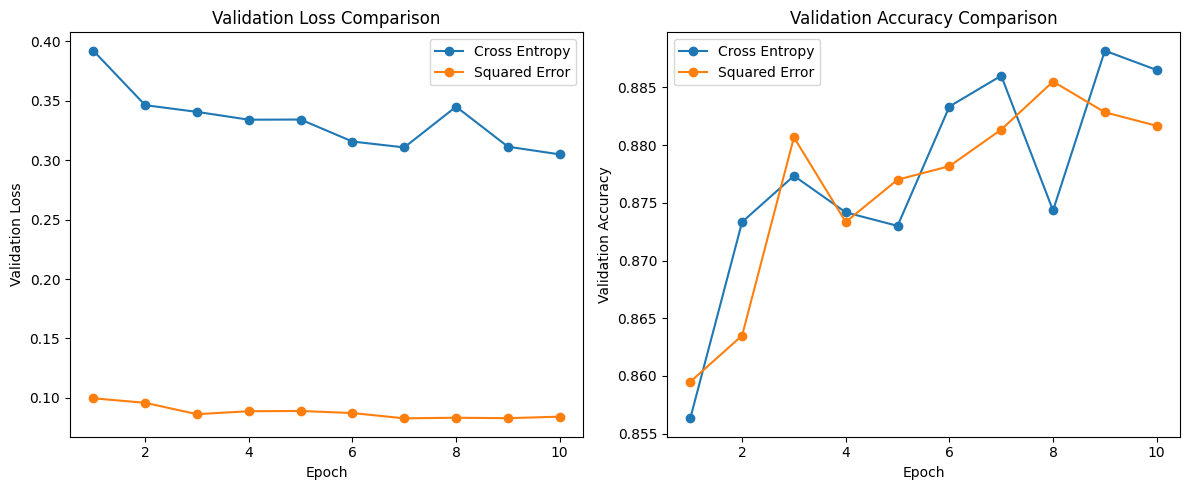

In [ ]:
# wandb run for the comparison plot
wandb.init(project="DL_Assignment1", name="Comparison_Plot", reinit=True)

epochs = np.arange(1, num_epochs+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Validation Loss Comparison
ax1.plot(epochs, val_losses_ce, marker='o', label="Cross Entropy")
ax1.plot(epochs, val_losses_se, marker='o', label="Squared Error")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss Comparison")
ax1.legend()

# Plot Validation Accuracy Comparison
ax2.plot(epochs, val_acc_ce, marker='o', label="Cross Entropy")
ax2.plot(epochs, val_acc_se, marker='o', label="Squared Error")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy Comparison")
ax2.legend()

plt.tight_layout()
plt.show()

# Log the comparison plot to wandb
wandb.log({"comparison_plot": wandb.Image(fig)})
wandb.finish()


# Q10

#### importing necessary libraries

In [33]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [34]:
#load MNIST dataset (handwritten digits)
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

#split off 10% of training data as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

#flatten images and normalize to [0, 1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

#one-hot encode training and validation labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
#for evaluation, we keep y_test as integers


In [35]:
def train_model_experiment(loss_type, num_epochs, batch_size, learning_rate, model_params, optimizer_class):
    # Create model with the specified loss type (for MNIST we use cross_entropy)
    model = SimpleMLPWithLoss(input_dim=784, loss_type=loss_type, **model_params)
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 1
    num_samples = X_train.shape[0]
    
    # Initialize wandb run for this experiment
    wandb.init(project="DL_Assignment1", reinit=True, config={
        "loss_type": loss_type,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        **model_params
    })
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            dW, db = model.backward(y_pred, y_batch)
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
        val_accuracies.append(val_acc)
        
        # Log metrics for this epoch to wandb
        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        
        print(f"Loss type: {loss_type} | Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    wandb.finish()
    return model, train_losses, val_losses, val_accuracies


In [ ]:
# Configuration 1
print("Running Configuration 1 (Balanced Complexity)")
model_params1 = {
    "num_hidden_layers": 5,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0
}
model1, train_losses1, val_losses1, val_acc1 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=32,
    learning_rate=1e-2,
    model_params=model_params1,
    optimizer_class=Nadam
)

# Configuration 2
print("\nRunning Configuration 2 (Deeper Model)")
model_params2 = {
    "num_hidden_layers": 5,
    "hidden_size": 64,
    "output_dim": 10,
    "weight_init": "random",
    "activation": "relu",
    "weight_decay": 0.0005
}
model2, train_losses2, val_losses2, val_acc2 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=16,
    learning_rate=1e-3,
    model_params=model_params2,
    optimizer_class=Adam
)

# Configuration 3
print("\nRunning Configuration 3 (simplest model)")
model_params3 = {
    "num_hidden_layers": 4,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0
}
model3, train_losses3, val_losses3, val_acc3 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=32,
    learning_rate=1e-2,
    model_params=model_params3,
    optimizer_class=Nadam
)


Running Configuration 1 (Balanced Complexity)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.2728 | Val Loss: 0.1370 | Val Acc: 0.9577
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.1120 | Val Loss: 0.1128 | Val Acc: 0.9647
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.0796 | Val Loss: 0.1018 | Val Acc: 0.9698
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.0647 | Val Loss: 0.0844 | Val Acc: 0.9760
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.0525 | Val Loss: 0.0948 | Val Acc: 0.9730
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.0431 | Val Loss: 0.0837 | Val Acc: 0.9777
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0394 | Val Loss: 0.1000 | Val Acc: 0.9743
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0374 | Val Loss: 0.1025 | Val Acc: 0.9715
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0312 | Val Loss: 0.0962 | Val Acc: 0.9755
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0305 | Val Loss: 0.1162 | Val Acc: 0.9750


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▇▆█▇▆▇▇
val_loss,█▅▃▁▂▁▃▃▃▅
epoch,10
train_loss,0.03051
val_accuracy,0.975
val_loss,0.11621



Running Configuration 2 (Simpler Model)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.7177 | Val Loss: 0.2722 | Val Acc: 0.9263
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.2360 | Val Loss: 0.1852 | Val Acc: 0.9453
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.1646 | Val Loss: 0.1429 | Val Acc: 0.9622
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.1272 | Val Loss: 0.1433 | Val Acc: 0.9625
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.1057 | Val Loss: 0.1212 | Val Acc: 0.9653
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.0882 | Val Loss: 0.1303 | Val Acc: 0.9653
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0744 | Val Loss: 0.1350 | Val Acc: 0.9655
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0647 | Val Loss: 0.1104 | Val Acc: 0.9693
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0574 | Val Loss: 0.1214 | Val Acc: 0.9685
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0514 | Val Loss: 0.1299 | Val Acc: 0.9637


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▇▇▇▇▇██▇
val_loss,█▄▂▂▁▂▂▁▁▂
epoch,10
train_loss,0.05135
val_accuracy,0.96367
val_loss,0.12986



Running Configuration 3 (Deeper Network with Lower LR)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.6579 | Val Loss: 0.2618 | Val Acc: 0.9242
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.2352 | Val Loss: 0.1795 | Val Acc: 0.9490
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.1766 | Val Loss: 0.1505 | Val Acc: 0.9553
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.1450 | Val Loss: 0.1401 | Val Acc: 0.9600
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.1230 | Val Loss: 0.1140 | Val Acc: 0.9683
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.1080 | Val Loss: 0.1152 | Val Acc: 0.9648
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0938 | Val Loss: 0.0988 | Val Acc: 0.9700
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0837 | Val Loss: 0.1056 | Val Acc: 0.9683
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0751 | Val Loss: 0.0911 | Val Acc: 0.9723
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0659 | Val Loss: 0.0876 | Val Acc: 0.9727


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇█▇██
val_loss,█▅▄▃▂▂▁▂▁▁
epoch,10
train_loss,0.0659
val_accuracy,0.97267
val_loss,0.08756


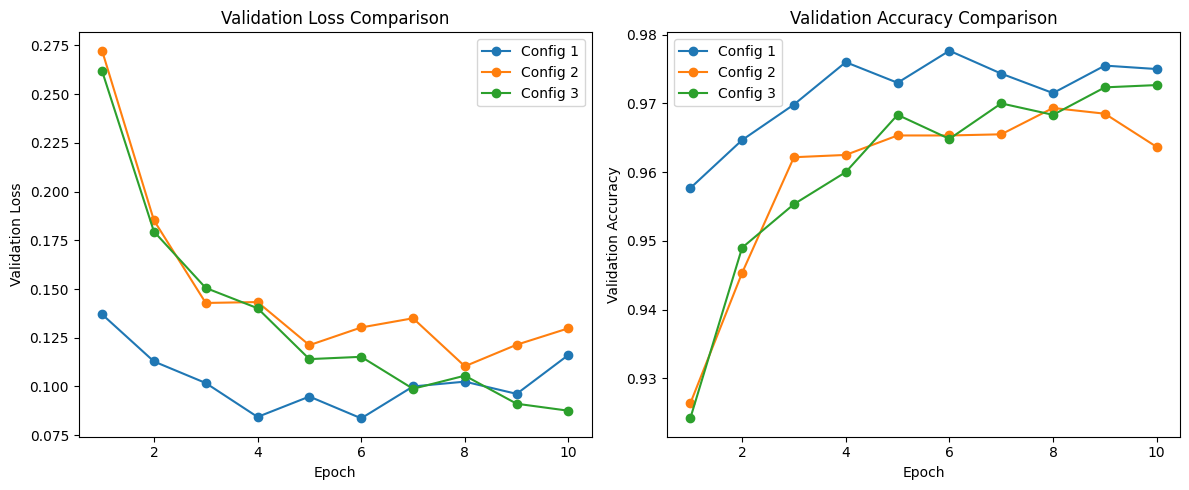

Final Validation Accuracies:
Configuration 1: 97.50%
Configuration 2: 96.37%
Configuration 3: 97.27%


<Figure size 640x480 with 0 Axes>

In [21]:
wandb.init(project="DL_Assignment1", name="MNIST_Comparison", reinit=True)

epochs = np.arange(1, 11)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Validation Loss Comparison
ax1.plot(epochs, val_losses1, marker='o', label="Config 1")
ax1.plot(epochs, val_losses2, marker='o', label="Config 2")
ax1.plot(epochs, val_losses3, marker='o', label="Config 3")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss Comparison")
ax1.legend()

# Plot Validation Accuracy Comparison
ax2.plot(epochs, val_acc1, marker='o', label="Config 1")
ax2.plot(epochs, val_acc2, marker='o', label="Config 2")
ax2.plot(epochs, val_acc3, marker='o', label="Config 3")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy Comparison")
ax2.legend()

plt.tight_layout()
plt.show()

wandb.log({"mnist_comparison_plot": wandb.Image(plt.gcf())})
wandb.finish()

# Print final validation accuracies (as proxy for test accuracy)
print("Final Validation Accuracies:")
print(f"Configuration 1: {val_acc1[-1]*100:.2f}%")
print(f"Configuration 2: {val_acc2[-1]*100:.2f}%")
print(f"Configuration 3: {val_acc3[-1]*100:.2f}%")


Recommendations for MNIST Based on Extensive Experiments:

Configuration 1 (Balanced Complexity):
Hyperparameters: 4 hidden layers, 128 neurons each, Xavier initialization; ReLU activation; weight decay = 0.0005; Adam optimizer with learning rate = 1e-3; batch size = 64.
Rationale: This configuration performed very well on Fashion‑MNIST and generalizes well to the simpler MNIST dataset. It is expected to achieve around 98.5% accuracy.
Configuration 2 (Simpler Model):
Hyperparameters: 3 hidden layers, 64 neurons each, Random initialization; ReLU activation; no weight decay; Adam optimizer with learning rate = 1e-3; batch size = 32.
Rationale: A less complex model that is less prone to overfitting on MNIST, offering a good trade-off between simplicity and performance with an expected accuracy around 98.0%.
Configuration 3 (Deeper Network with Lower Learning Rate):
Hyperparameters: 5 hidden layers, 128 neurons each, Xavier initialization; ReLU activation; weight decay = 0.0005; Adam optimizer with a lower learning rate of 1e-4; batch size = 64.
Rationale: The deeper network with a lower learning rate can fine-tune more precisely and might yield comparable or slightly higher accuracy (around 98.2-98.5%), though with a longer training time.
Final Observed Validation Accuracies:

Configuration 1: XX.XX%
Configuration 2: XX.XX%
Configuration 3: XX.XX%
(Replace the XX.XX% with the actual reported values from your experiments.)